In [246]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

- Clean notebook to be only new 
- Be able to merge train features and train targets
- same with test
- be able to then split and run program
- test for overfit
- create additional features (business/extra features from swing/ extra features from bugs)
- run reviews for NLP

In [247]:
list_of_file_names = glob.glob("./zip_2/*.csv")

In [248]:
read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        #data = unicode(data, errors='replace')
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
#read_data_list
#fail_list
list_of_file_names_org = list_of_file_names

In [249]:
fail_list

[3]

In [250]:
for x in fail_list:
    del list_of_file_names[x]

In [251]:
list_of_file_names[23]

'./zip_2/Zip_MedianListingPricePerSqft_AllHomes.csv'

In [252]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset].copy()
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [253]:
useful_df = build_useful_df(read_data_list_2)


In [254]:
sixteen_list = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)

In [255]:
len(sixteen_list)

30

In [256]:
good_columns = []
for i, file in enumerate(useful_df):
    columns = file.columns
    if '2017-01' in columns:
        good_columns.append(i)

In [257]:
sixteen_good = []
for num in sixteen_list:
    if num in good_columns:
        sixteen_good.append(num)

In [258]:
len(sixteen_good)

12

In [259]:
target_data = useful_df[23]

In [260]:
final_data_list = []
for i, data in enumerate(useful_df):
    if i in sixteen_good:
        final_data_list.append(data)

In [261]:
len(final_data_list[3])

10066

In [262]:
# Docs that don't need feature engineering. They are already aggregates
pure_features = [0, 71, 75, 77, 79, 81]
useful_df[0].head()

,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro
RegionName,,,,
99654,11.142857,82.0,9.230769,7.260083
99645,7.589286,74.0,0.769231,7.260083
99577,8.108108,79.5,4.615385,7.260083
99567,9.836066,76.0,2.307692,7.260083
99518,14.925373,85.0,10.000000,7.260083


In [263]:
def make_features(df, past_time_string, now_string):
    #df.dropna(inplace=True)
    features = pd.DataFrame()
    #features['RegionName'] = df['RegionName']
    mean = df.loc[:, past_time_string : now_string].mean(axis=1)
    features['mean'] = mean
    std = df.loc[:, past_time_string : now_string].std(axis=1)
    features['std'] = std
    mn = df.loc[:, past_time_string : now_string].min(axis=1)
    features['min'] = mn
    mx = df.loc[:, past_time_string : now_string].max(axis=1)
    features['max'] = mx
    features['swing'] = mx - mn
    change = df[now_string] - df[past_time_string]
    features['change'] = change
    mean_swing = features['swing'].mean()
    features['swing_pos'] = np.where(features['swing']>mean_swing, 1, 0)
    big_swing = features['swing'].std() + mean_swing
    features['swing_big'] = np.where(features['swing']>big_swing, 1, 0)
    features['swing_neg'] = np.where(features['swing']<mean_swing, 1, 0)
    swing_big_loss = mean_swing - features['swing'].std() 
    features['swing_loss_big'] = np.where(features['swing']<swing_big_loss, 1, 0)
    #features.dropna(inplace=True)
    
    #features = features.set_index(df.index)
    #print(features.iloc[1, :])
    return features
    
# List of data frames only on one now_time
def make_modeling_data(df_list, df_for_target, now_string):
    df_one = pd.DataFrame()
    target = pd.DataFrame()
    now_time = pd.to_datetime(now_string)
    now_value = df_for_target[now_string]
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    future_value = df_for_target[future_time_string]
    target['target'] = future_value/now_value
    
    
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    df_to_use_for_features_org= df_list[0].loc[:, :now_string]
    features_org = make_features(df_to_use_for_features_org, past_time_string, now_string)
    df_one = pd.merge(df_one, features_org, left_index=True, right_index=True, how = 'right')
    for i, df in enumerate(df_list[1:]):
        ind = str(i)
        columns = df.columns
        if '2011-01' in columns and '2012-01' in columns and '2013-01' in columns and '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
            df_to_use_for_features= df.loc[:, :now_string]
            features = make_features(df_to_use_for_features, past_time_string, now_string)
            df_one = pd.merge(df_one, features, right_index=True, left_index=True, how='inner')
    target = target.loc[df_one.index]    
    #now_time = pd.to_datetime(now_string)
    #now_value = df_for_target[now_string]
    #future_time = now_time + timedelta(days=6*31)
    #future_time_string= future_time.strftime("%Y-%m")
    #future_value = df_for_target[future_time_string]
            #target = future_value/now_value

    
    return df_one, target




test_features, test_targets = make_modeling_data(final_data_list, target_data, "2017-06")
train_features, train_targets = make_modeling_data(final_data_list, target_data, "2017-01")
#extra_train_features_1, extra_train_targets_1 = make_modeling_data(final_data_list, target_data, '2016-06')
train_features = train_features.append(train_features)
train_targets = train_targets.append(train_targets)






#df = useful_df[num]
#columns = df.columns
#"2012", "2012", "2013",
date_counter = 0
for year in ["2012", "2013", "2014", "2015", "2016"]:
    for month in ["06","12"]:
            new_time = year+"-"+month
            date_counter += 1
            #if '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
                    #extra_train_features, extra_train_targets = make_modeling_data(df, new_time)
                    #train_features = train_features.append(extra_train_features)
                    #train_targets = train_targets.append(extra_train_targets)
            extra_train_features, extra_train_targets = make_modeling_data(final_data_list, target_data, new_time)
            #extra_train_features.dropna(inplace=True)
            train_features = train_features.append(extra_train_features)
            train_targets = train_targets.append(extra_train_targets)

In [264]:
train_targets.shape

(66132, 1)

In [265]:
train_features.shape

(66132, 120)

In [266]:
train_targets.head()

,target
RegionName,
99362,1.047544
99353,1.122185
99352,1.061993
99338,1.073945
99337,1.084956


#### Have not worked on w2v today; focused on business

In [267]:
w2v_features = pd.read_csv('real_business_w2v_features_3_6')

In [268]:
w2v_features['postal_code'] = w2v_features['postal_code'].astype(str)

In [269]:
w2v_features.shape

(959, 512)

In [270]:
w2v_features.index = w2v_features['postal_code']

In [271]:
w2v_features = w2v_features.iloc[:, 1:]

In [272]:
w2v_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min,...,490,491,492,493,494,495,496,497,498,499
postal_code,,,,,,,,,,,,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0,...,-0.007905,-0.050745,0.019509,0.089886,-0.067859,-0.057686,-0.073559,0.004500,-0.062522,0.054272
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0,...,0.024744,0.024881,0.039596,0.043280,-0.032233,-0.017144,0.060047,-0.002217,0.063483,-0.041164
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0,...,-0.032312,-0.024693,-0.019165,0.015924,-0.044335,-0.020998,0.041530,-0.048317,0.086379,-0.008370
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0,...,-0.014649,0.000344,0.033006,-0.015937,0.011044,0.094979,0.085854,-0.037768,-0.038649,0.033392
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0,...,-0.013431,0.007048,0.017738,-0.013003,0.016217,0.083113,0.092610,-0.032904,-0.048000,0.023717


#### Here is where business is imported

In [273]:
# Up to date business features where all rows are a singular zipcode
business_features = pd.read_csv('real_business_features_3_4')

In [274]:
len(business_features)

959

In [275]:
business_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 11 columns):
postal_code             959 non-null int64
is_open                 959 non-null float64
latitude                959 non-null float64
longitude               959 non-null float64
review_count            959 non-null float64
stars                   959 non-null float64
average_review_count    959 non-null float64
business_count          959 non-null float64
zip_review_count        959 non-null float64
average_review_max      959 non-null float64
average_review_min      959 non-null float64
dtypes: float64(10), int64(1)
memory usage: 82.5 KB


In [276]:
business_features.shape

(959, 11)

In [277]:
business_features['postal_code'] = business_features['postal_code'].astype(str)

In [278]:
business_features['postal_code'].nunique()

959

In [279]:
business_features = business_features.set_index('postal_code')

In [280]:
business_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min
postal_code,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0


In [281]:
train_features.shape

(66132, 120)

In [282]:
train_features = train_features.reset_index()

In [283]:
test_features = test_features.reset_index()

In [284]:
len(test_features)

5511

In [285]:
train_targets = train_targets.reset_index()

In [286]:
test_targets = test_targets.reset_index()

In [287]:
business_features_index = business_features.index.unique()

In [288]:
region_name_list = train_features['RegionName'].unique()

In [289]:
shared_list = []
for zipc in business_features_index:
    if zipc in region_name_list:
        shared_list.append(zipc)

In [290]:
len(shared_list)

333

In [291]:
len(train_features)

66132

In [292]:
# Merging on index for train features and targets so it doesn't multiply 
train_merge = pd.merge(train_features, train_targets, right_index=True, left_index=True, how='inner')

In [293]:
test_merge = pd.merge(test_features, test_targets, right_index=True, left_index=True, how='inner')

In [294]:
len(train_merge)

66132

In [295]:
test_merge.head()

,RegionName_x,mean_x,std_x,min_x,max_x,swing_x,change_x,swing_pos_x,swing_big_x,swing_neg_x,...,min_y,max_y,swing_y,change_y,swing_pos_y,swing_big_y,swing_neg_y,swing_loss_big_y,RegionName_y,target
0,99362,9.899305,2.694838,7.225547,15.562721,8.337174,-8.337174,0,0,1,...,0.874,0.894,0.020,0.018,0,0,1,0,99362,1.000168
1,99353,12.713502,4.201132,8.701869,20.788350,12.086481,6.728607,1,1,0,...,0.874,0.886,0.012,-0.010,0,0,1,0,99353,1.137133
2,99352,13.114296,2.222078,10.907130,17.667674,6.760545,2.172499,0,0,1,...,0.900,0.908,0.008,-0.004,0,0,1,0,99352,1.011334
3,99338,10.337470,2.859324,6.462035,15.113417,8.651382,-1.678754,1,0,0,...,0.884,0.896,0.012,0.008,0,0,1,0,99338,1.014762
4,99337,12.309892,3.922309,7.724349,18.444138,10.719789,-6.511823,1,0,0,...,0.878,0.890,0.012,0.012,0,0,1,0,99337,1.062254


In [296]:
train_merge = train_merge.set_index('RegionName_x')

In [297]:
test_merge = test_merge.set_index('RegionName_x')

In [298]:
train_merge.shape

(66132, 122)

In [299]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66132 entries, 99362 to 1001
Columns: 122 entries, mean_x to target
dtypes: float64(73), int64(48), object(1)
memory usage: 62.1+ MB


In [300]:
business_features.shape

(959, 10)

In [301]:
train_merge['RegionName_y'].nunique()

5511

In [302]:
business_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [303]:
business_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [304]:
w2v_train_merge = pd.merge(train_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [305]:
w2v_test_merge = pd.merge(test_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [306]:
new_zillow_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [307]:
nztmc = new_zillow_test_merge.columns
test_merge = new_zillow_test_merge.iloc[:, :-10]

In [308]:
new_zillow_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [309]:
train_merge = new_zillow_train_merge.iloc[:, :-10]

In [310]:
len(train_merge.columns)

122

In [311]:
len(test_merge.columns)

122

In [312]:
# This should have all instances of the train and test. 
business_train_merge.shape

(3996, 132)

In [313]:
w2v_train_merge.shape

(3996, 633)

In [314]:
# Is it ok that I have multiple of the aggregated information from Yelp?
business_train_merge.head(11)

,mean_x,std_x,min_x,max_x,swing_x,change_x,swing_pos_x,swing_big_x,swing_neg_x,swing_loss_big_x,...,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min
15003,14.464006,2.323347,11.537536,18.258360,6.720823,5.131603,0,0,1,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,14.464006,2.323347,11.537536,18.258360,6.720823,5.131603,0,0,1,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,13.066543,2.749281,9.918464,18.321159,8.402695,-1.485973,1,0,0,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,14.267149,3.381999,9.615653,19.912455,10.296802,-3.850137,1,0,0,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,15.460086,3.876415,9.615653,20.093610,10.477957,8.783796,1,0,0,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,16.248923,2.768642,11.968512,21.010779,9.042267,2.144157,1,0,0,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,16.116125,4.855846,8.884885,24.155285,15.270400,2.256744,1,1,0,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,16.885622,3.206663,13.813915,24.155285,10.341370,-8.362070,1,0,0,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,13.163923,2.375110,9.706724,16.074128,6.367404,-2.375702,0,0,1,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,14.980037,2.924676,9.706724,19.470481,9.763757,8.018858,1,0,0,0,...,0.916667,40.59825,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0


In [315]:
train_merge = train_merge.drop('RegionName_y', 1)

In [316]:
test_merge = test_merge.drop('RegionName_y', 1)

### Most up to date Business attempt
- Why is y glitching with NaN?
- Update I have not removed any NaN's yet

In [317]:
train_merge.columns

Index(['mean_x', 'std_x', 'min_x', 'max_x', 'swing_x', 'change_x',
       'swing_pos_x', 'swing_big_x', 'swing_neg_x', 'swing_loss_big_x',
       ...
       'std_y', 'min_y', 'max_y', 'swing_y', 'change_y', 'swing_pos_y',
       'swing_big_y', 'swing_neg_y', 'swing_loss_big_y', 'target'],
      dtype='object', length=121)

In [318]:
train_merge.dropna(inplace=True)

In [319]:
test_merge.dropna(inplace=True)

In [320]:
train_merge.index.nunique()

326

In [321]:
test_merge.index.nunique()

331

In [322]:
business_train_merge.dropna(inplace=True)

In [323]:
business_test_merge.dropna(inplace=True)

In [324]:
w2v_train_merge.dropna(inplace=True)

In [325]:
w2v_test_merge.dropna(inplace=True)

In [326]:
w2v_train_merge.index.nunique()

326

In [327]:
w2v_test_merge.index.nunique()

331

In [328]:
# 169 zipcodes in common after dropna. Had about double that before
business_test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331 entries, 95966 to 15003
Columns: 132 entries, mean_x to average_review_min
dtypes: float64(83), int64(48), object(1)
memory usage: 343.9+ KB


In [329]:
col = w2v_test_merge.columns

In [330]:
col[120:130]

Index(['RegionName_y', 'target', 'is_open', 'latitude', 'longitude',
       'review_count', 'stars', 'average_review_count', 'business_count',
       'zip_review_count'],
      dtype='object')

In [331]:
X_train = train_merge.iloc[:, :-1].values
y_train = train_merge.iloc[:, -1].values
X_test = test_merge.iloc[:, :-1].values
y_test = test_merge.iloc[:, -1].values

In [332]:
w2v_train_merge = w2v_train_merge.drop('RegionName_y', 1)
w2v_test_merge = w2v_test_merge.drop('RegionName_y', 1)
y_train_w2v = w2v_train_merge.loc[:, 'target'].values
y_test_w2v = w2v_test_merge.loc[:, 'target'].values
w2v_train = pd.DataFrame()
w2v_train_features = w2v_train_merge.drop('target', 1).values
X_train_w2v = pd.DataFrame()
X_train_w2v = w2v_train_features
X_test_w2v_features = pd.DataFrame()
X_test_w2v_features = w2v_test_merge.drop('target', 1).values
X_test_w2v = pd.DataFrame()
X_test_w2v = X_test_w2v_features

In [333]:
# Setting up train and test
business_train_merge = business_train_merge.drop('RegionName_y', 1)
business_test_merge = business_test_merge.drop('RegionName_y', 1)
y_train_business = business_train_merge.loc[:, 'target'].values
y_test_business = business_test_merge.loc[:, 'target'].values
business_train = pd.DataFrame()
business_train_features = business_train_merge.drop('target', 1).values
X_train_business = pd.DataFrame()
X_train_business = business_train_features
X_test_business_features = pd.DataFrame()
X_test_business_features = business_test_merge.drop('target', 1).values
X_test_business = pd.DataFrame()
X_test_business = X_test_business_features

In [334]:
X_test_business.shape

(331, 130)

In [335]:
X_train_w2v.shape

(2839, 631)

In [336]:
X_test_w2v.shape

(331, 631)

In [337]:
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [338]:
X_train = norm_per_column(X_train)
X_test = norm_per_column(X_test)

In [339]:
X_train_business = norm_per_column(X_train_business)
X_test_business = norm_per_column(X_test_business)

In [340]:
X_train_w2v = norm_per_column(X_train_w2v)
X_test_w2v = norm_per_column(X_test_w2v)

In [373]:
y_test.var()

0.0028560998107322942

In [486]:
print(y_train.mean())
print(y_train.min())
print(y_train.max())

1.03568676443
0.809566962437
1.32300764356


In [487]:
print(y_test.mean())
print(y_test.min())
print(y_test.max())

1.01812630226
0.833675690212
1.18704258259


In [532]:
def create_y_class_2(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    
    for y in y_list:
        if y <= .9:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .9 and y <= .97:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .97 and y < 1.03:
            y_3.append(1)
        else:
            y_3.append(0)
        if y >= 1.03 and y < 1.1:
            y_4.append(1)
        else:
            y_4.append(0)
        if y >= 1.1:
            y_5.append(1)
        else:
            y_5.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    return y_df

In [417]:
def create_y_class(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    y_6 = []
    y_7 = []
    for y in y_list:
        if y <= .89:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .89 and y <= .95:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .95 and y <= 1.01:
            y_3.append(1)
        else:
            y_3.append(0)
        if y > 1.01 and y <= 1.07:
            y_4.append(1)
        else:
            y_4.append(0)
        if y > 1.07 and y <= 1.13:
            y_5.append(1)
        else:
            y_5.append(0)
        if y > 1.13 and y <= 1.19:
            y_6.append(1)
        else:
            y_6.append(0)
        if y > 1.19:
            y_7.append(1)
        else:
            y_7.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    y_df['6'] = y_6
    y_df['7'] = y_7
    return y_df

In [533]:
y_cat_train = create_y_class_2(y_train)

In [534]:
y_cat_test = create_y_class_2(y_test)

In [535]:
y_cat_train_w2v = create_y_class_2(y_train_w2v)

In [536]:
y_cat_test_w2v = create_y_class_2(y_test_w2v)

In [537]:
y_cat_train_business = create_y_class_2(y_train_business)

In [538]:
y_cat_test_business = create_y_class_2(y_test_business)

In [539]:
y_cat_test['5'].sum()

20

In [540]:
y_test_business.var()

0.0028560998107322942

In [354]:
# Hold overfit model for now
model = Sequential()
model.add(Dense(3000, input_shape=(110,), activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer='Adam',
              loss='mean_squared_error')

In [108]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.005)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [109]:
model.fit(x=X_train, y=y_train, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 1s 236us/step - loss: 5.0520 - val_loss: 0.8179
Epoch 2/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.7713 - val_loss: 0.3394
Epoch 3/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.3612 - val_loss: 0.2371
Epoch 4/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.2764 - val_loss: 0.1511
Epoch 5/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.2429 - val_loss: 0.2028
Epoch 6/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.2299 - val_loss: 0.2910
Epoch 7/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.2521 - val_loss: 0.2652
Epoch 8/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.2281 - val_loss: 0.2487
Epoch 9/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.2222 - val_loss: 0.2714
Epoch 10/500
283

2839/2839 [==============================] - 0s 28us/step - loss: 0.0288 - val_loss: 0.0085
Epoch 79/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0262 - val_loss: 0.0080
Epoch 80/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0244 - val_loss: 0.0064
Epoch 81/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0244 - val_loss: 0.0034
Epoch 82/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0232 - val_loss: 0.0029
Epoch 83/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0228 - val_loss: 0.0033
Epoch 84/500
2839/2839 [==============================] - ETA: 0s - loss: 0.022 - 0s 30us/step - loss: 0.0216 - val_loss: 0.0048
Epoch 85/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0216 - val_loss: 0.0069
Epoch 86/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0240 - val_loss: 0.0053
Epoch 87/500
2839/2839 [====================

2839/2839 [==============================] - 0s 25us/step - loss: 0.0059 - val_loss: 0.0026
Epoch 156/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0053 - val_loss: 0.0029
Epoch 157/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0051 - val_loss: 0.0032
Epoch 158/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0059 - val_loss: 0.0027
Epoch 159/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0049 - val_loss: 0.0029
Epoch 160/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.0050 - val_loss: 0.0030
Epoch 161/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0048 - val_loss: 0.0030
Epoch 162/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0047 - val_loss: 0.0031
Epoch 163/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0044 - val_loss: 0.0032
Epoch 164/500
2839/2839 [==============================] - E

2839/2839 [==============================] - 0s 26us/step - loss: 0.0020 - val_loss: 0.0086
Epoch 233/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0025 - val_loss: 0.0050
Epoch 234/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0021 - val_loss: 0.0054
Epoch 235/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0019 - val_loss: 0.0065
Epoch 236/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 0.0062
Epoch 237/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0024 - val_loss: 0.0064
Epoch 238/500
2839/2839 [==============================] - 0s 35us/step - loss: 0.0022 - val_loss: 0.0064
Epoch 239/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0021 - val_loss: 0.0056
Epoch 240/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0022 - val_loss: 0.0061
Epoch 241/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 27us/step - loss: 0.0018 - val_loss: 0.0068
Epoch 310/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0019 - val_loss: 0.0076
Epoch 311/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0022 - val_loss: 0.0066
Epoch 312/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0021 - val_loss: 0.0053
Epoch 313/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0017 - val_loss: 0.0064
Epoch 314/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.0017 - val_loss: 0.0070
Epoch 315/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0019 - val_loss: 0.0061
Epoch 316/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0019 - val_loss: 0.0069
Epoch 317/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0018 - val_loss: 0.0064
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 27us/step - loss: 0.0021 - val_loss: 0.0057
Epoch 387/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0016 - val_loss: 0.0063
Epoch 388/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0015 - val_loss: 0.0070
Epoch 389/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0015 - val_loss: 0.0068
Epoch 390/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0017 - val_loss: 0.0082
Epoch 391/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0019 - val_loss: 0.0095
Epoch 392/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0025 - val_loss: 0.0065
Epoch 393/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0017 - val_loss: 0.0068
Epoch 394/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0017 - val_loss: 0.0069
Epoch 395/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 28us/step - loss: 0.0016 - val_loss: 0.0059
Epoch 464/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0014 - val_loss: 0.0068
Epoch 465/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0016 - val_loss: 0.0071
Epoch 466/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0020 - val_loss: 0.0074
Epoch 467/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.0019 - val_loss: 0.0052
Epoch 468/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0015 - val_loss: 0.0057
Epoch 469/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0015 - val_loss: 0.0061
Epoch 470/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0017 - val_loss: 0.0088
Epoch 471/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0023 - val_loss: 0.0061
Epoch 472/500
2839/2839 [==============================] - 0

In [110]:
#loss = .00001441 (overfit) = .0038

#std = .072

In [111]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.01)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [112]:
model.fit(x=X_train_business, y=y_train_business, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 1s 216us/step - loss: 102.0821 - val_loss: 1.4821
Epoch 2/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.1341 - val_loss: 0.2196
Epoch 3/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.1817 - val_loss: 0.0314
Epoch 4/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0701 - val_loss: 0.0266
Epoch 5/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0657 - val_loss: 0.0245
Epoch 6/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0631 - val_loss: 0.0236
Epoch 7/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0640 - val_loss: 0.0221
Epoch 8/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0590 - val_loss: 0.0209
Epoch 9/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0551 - val_loss: 0.0190
Epoch 10/500
2

Epoch 78/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0369 - val_loss: 0.0637
Epoch 79/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0661 - val_loss: 0.0851
Epoch 80/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0725 - val_loss: 0.0168
Epoch 81/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0257 - val_loss: 0.0227
Epoch 82/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0328 - val_loss: 0.0473
Epoch 83/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0509 - val_loss: 0.0493
Epoch 84/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0494 - val_loss: 0.0221
Epoch 85/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0298 - val_loss: 0.0179
Epoch 86/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0266 - val_loss: 0.0308
Epoch 87/500
2839/2839 [==============================]

2839/2839 [==============================] - 0s 30us/step - loss: 0.0099 - val_loss: 0.0060
Epoch 156/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0088 - val_loss: 0.0053
Epoch 157/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0076 - val_loss: 0.0039
Epoch 158/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0068 - val_loss: 0.0041
Epoch 159/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0064 - val_loss: 0.0035
Epoch 160/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0060 - val_loss: 0.0035
Epoch 161/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0062 - val_loss: 0.0048
Epoch 162/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0070 - val_loss: 0.0055
Epoch 163/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0078 - val_loss: 0.0065
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 43us/step - loss: 0.0074 - val_loss: 0.0026
Epoch 233/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.0046 - val_loss: 0.0025
Epoch 234/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0039 - val_loss: 0.0028
Epoch 235/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 236/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0082 - val_loss: 0.0064
Epoch 237/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.0084 - val_loss: 0.0025
Epoch 238/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 239/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0040 - val_loss: 0.0026
Epoch 240/500
2839/2839 [==============================] - 0s 36us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 241/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 28us/step - loss: 0.0037 - val_loss: 0.0028
Epoch 310/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 311/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0042 - val_loss: 0.0028
Epoch 312/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0043 - val_loss: 0.0030
Epoch 313/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0044 - val_loss: 0.0025
Epoch 314/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 315/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 316/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0039 - val_loss: 0.0028
Epoch 317/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0042 - val_loss: 0.0024
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 28us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 387/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 388/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0028 - val_loss: 0.0033
Epoch 389/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0047
Epoch 390/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 391/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0032 - val_loss: 0.0034
Epoch 392/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0031 - val_loss: 0.0045
Epoch 393/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 394/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0031 - val_loss: 0.0036
Epoch 395/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 27us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 464/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0027 - val_loss: 0.0049
Epoch 465/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0032 - val_loss: 0.0063
Epoch 466/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 467/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0023 - val_loss: 0.0043
Epoch 468/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0026 - val_loss: 0.0065
Epoch 469/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0026 - val_loss: 0.0046
Epoch 470/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0028 - val_loss: 0.0062
Epoch 471/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0032 - val_loss: 0.0046
Epoch 472/500
2839/2839 [==============================] - 0

In [113]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [115]:
model.fit(x=X_train_w2v, y=y_train_w2v, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0019 - val_loss: 0.0027
Epoch 2/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0020 - val_loss: 0.0026
Epoch 3/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 4/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0019 - val_loss: 0.0027
Epoch 5/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 6/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 8/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/500
2839

2839/2839 [==============================] - 0s 74us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 79/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 80/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 81/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 82/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0016 - val_loss: 0.0025
Epoch 83/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 84/500
2839/2839 [==============================] - 0s 59us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 85/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 86/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 87/500
2839/2839 [==============================] - 0s 62us/st

2839/2839 [==============================] - 0s 72us/step - loss: 0.0014 - val_loss: 0.0030
Epoch 156/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.0020 - val_loss: 0.0026
Epoch 157/500
2839/2839 [==============================] - 0s 94us/step - loss: 0.0016 - val_loss: 0.0026
Epoch 158/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0016 - val_loss: 0.0029
Epoch 159/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.0018 - val_loss: 0.0027
Epoch 160/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 161/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 162/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0014 - val_loss: 0.0028
Epoch 163/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 79us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 233/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 234/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0013 - val_loss: 0.0029
Epoch 235/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 236/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 237/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0014 - val_loss: 0.0026
Epoch 238/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 239/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0014 - val_loss: 0.0026
Epoch 240/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 241/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 0.0025
Epoch 310/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 311/500
2839/2839 [==============================] - 0s 81us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 312/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0014 - val_loss: 0.0028
Epoch 313/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0013 - val_loss: 0.0026
Epoch 314/500
2839/2839 [==============================] - ETA: 0s - loss: 0.001 - 0s 70us/step - loss: 0.0012 - val_loss: 0.0023
Epoch 315/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 316/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0012 - val_loss: 0.0023
Epoch 317/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 318/500
2839/2839 [===========

Epoch 386/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 387/500
2839/2839 [==============================] - 0s 57us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 388/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0014 - val_loss: 0.0026
Epoch 389/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0013 - val_loss: 0.0026
Epoch 390/500
2839/2839 [==============================] - 0s 59us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 391/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0011 - val_loss: 0.0028
Epoch 392/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 393/500
2839/2839 [==============================] - 0s 58us/step - loss: 0.0011 - val_loss: 0.0029
Epoch 394/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0012 - val_loss: 0.0032
Epoch 395/500
2839/2839 [=====================

2839/2839 [==============================] - 0s 60us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 464/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 465/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 466/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 467/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.0012 - val_loss: 0.0029
Epoch 468/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.0013 - val_loss: 0.0029
Epoch 469/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0014 - val_loss: 0.0031
Epoch 470/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 471/500
2839/2839 [==============================] - 0s 58us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 472/500
2839/2839 [==============================] - 0

In [391]:
class_weight = {0 : 2,
    1: 1.25,
    2: .75,
    3: .25,
    4: .75,
    5: 1.25,
    6: 2}

In [676]:
class_weight = {0 : 2,
    1: 1,
    2: .5,
    3: 1,
    4: 2}

In [441]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [442]:
zillow_model = model.fit(x=X_train, y=y_cat_train, 
          batch_size=20000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 3s 894us/step - loss: 1.2431 - acc: 0.0588 - val_loss: 1.2546 - val_acc: 0.0846
Epoch 2/500
2839/2839 [==============================] - 0s 23us/step - loss: 1.2358 - acc: 0.0634 - val_loss: 1.2500 - val_acc: 0.0846
Epoch 3/500
2839/2839 [==============================] - 0s 23us/step - loss: 1.2332 - acc: 0.0634 - val_loss: 1.2461 - val_acc: 0.0846
Epoch 4/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.2304 - acc: 0.0627 - val_loss: 1.2427 - val_acc: 0.0846
Epoch 5/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.2258 - acc: 0.0673 - val_loss: 1.2396 - val_acc: 0.0846
Epoch 6/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.2235 - acc: 0.0645 - val_loss: 1.2367 - val_acc: 0.0846
Epoch 7/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.2208 - acc: 0.0722 - val_loss: 1.2340 - val_acc: 0.0846


Epoch 61/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.1308 - acc: 0.1627 - val_loss: 1.1325 - val_acc: 0.1178
Epoch 62/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.1317 - acc: 0.1687 - val_loss: 1.1309 - val_acc: 0.1148
Epoch 63/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.1307 - acc: 0.1761 - val_loss: 1.1293 - val_acc: 0.1148
Epoch 64/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.1276 - acc: 0.1793 - val_loss: 1.1277 - val_acc: 0.1178
Epoch 65/500
2839/2839 [==============================] - 0s 23us/step - loss: 1.1278 - acc: 0.1832 - val_loss: 1.1261 - val_acc: 0.1178
Epoch 66/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.1243 - acc: 0.1884 - val_loss: 1.1244 - val_acc: 0.1178
Epoch 67/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.1245 - acc: 0.1810 - val_loss: 1.1228 - val_acc: 0.1269
Epoch 68/500
2839/2839 [=================

Epoch 121/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.0614 - acc: 0.4723 - val_loss: 1.0472 - val_acc: 0.4260
Epoch 122/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.0598 - acc: 0.4850 - val_loss: 1.0460 - val_acc: 0.4381
Epoch 123/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.0595 - acc: 0.4935 - val_loss: 1.0448 - val_acc: 0.4441
Epoch 124/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.0585 - acc: 0.4900 - val_loss: 1.0436 - val_acc: 0.4441
Epoch 125/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.0584 - acc: 0.5041 - val_loss: 1.0424 - val_acc: 0.4471
Epoch 126/500
2839/2839 [==============================] - 0s 24us/step - loss: 1.0575 - acc: 0.4878 - val_loss: 1.0412 - val_acc: 0.4502
Epoch 127/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.0557 - acc: 0.5065 - val_loss: 1.0400 - val_acc: 0.4592
Epoch 128/500
2839/2839 [=========

Epoch 181/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.0051 - acc: 0.7432 - val_loss: 0.9816 - val_acc: 0.7825
Epoch 182/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.0054 - acc: 0.7485 - val_loss: 0.9806 - val_acc: 0.7885
Epoch 183/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.0061 - acc: 0.7383 - val_loss: 0.9796 - val_acc: 0.7976
Epoch 184/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.0037 - acc: 0.7450 - val_loss: 0.9786 - val_acc: 0.8006
Epoch 185/500
2839/2839 [==============================] - 0s 25us/step - loss: 1.0020 - acc: 0.7577 - val_loss: 0.9776 - val_acc: 0.8127
Epoch 186/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.0021 - acc: 0.7570 - val_loss: 0.9766 - val_acc: 0.8127
Epoch 187/500
2839/2839 [==============================] - 0s 26us/step - loss: 1.0012 - acc: 0.7471 - val_loss: 0.9756 - val_acc: 0.8218
Epoch 188/500
2839/2839 [=========

Epoch 241/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.9559 - acc: 0.8408 - val_loss: 0.9242 - val_acc: 0.8912
Epoch 242/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.9545 - acc: 0.8454 - val_loss: 0.9232 - val_acc: 0.8912
Epoch 243/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.9536 - acc: 0.8418 - val_loss: 0.9223 - val_acc: 0.8912
Epoch 244/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.9535 - acc: 0.8341 - val_loss: 0.9214 - val_acc: 0.8912
Epoch 245/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.9525 - acc: 0.8397 - val_loss: 0.9205 - val_acc: 0.8912
Epoch 246/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.9531 - acc: 0.8429 - val_loss: 0.9196 - val_acc: 0.8912
Epoch 247/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.9506 - acc: 0.8454 - val_loss: 0.9187 - val_acc: 0.8912
Epoch 248/500
2839/2839 [=========

Epoch 301/500
2839/2839 [==============================] - 0s 24us/step - loss: 0.9039 - acc: 0.8746 - val_loss: 0.8697 - val_acc: 0.8912
Epoch 302/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.9034 - acc: 0.8753 - val_loss: 0.8687 - val_acc: 0.8912
Epoch 303/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.9033 - acc: 0.8732 - val_loss: 0.8678 - val_acc: 0.8912
Epoch 304/500
2839/2839 [==============================] - 0s 24us/step - loss: 0.9033 - acc: 0.8746 - val_loss: 0.8669 - val_acc: 0.8912
Epoch 305/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.9019 - acc: 0.8778 - val_loss: 0.8660 - val_acc: 0.8912
Epoch 306/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.9005 - acc: 0.8757 - val_loss: 0.8651 - val_acc: 0.8912
Epoch 307/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.8995 - acc: 0.8746 - val_loss: 0.8642 - val_acc: 0.8912
Epoch 308/500
2839/2839 [=========

Epoch 361/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.8534 - acc: 0.8876 - val_loss: 0.8138 - val_acc: 0.8912
Epoch 362/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.8500 - acc: 0.8887 - val_loss: 0.8129 - val_acc: 0.8912
Epoch 363/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.8525 - acc: 0.8855 - val_loss: 0.8119 - val_acc: 0.8912
Epoch 364/500
2839/2839 [==============================] - 0s 27us/step - loss: 0.8482 - acc: 0.8862 - val_loss: 0.8110 - val_acc: 0.8912
Epoch 365/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.8503 - acc: 0.8894 - val_loss: 0.8100 - val_acc: 0.8912
Epoch 366/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.8464 - acc: 0.8890 - val_loss: 0.8090 - val_acc: 0.8912
Epoch 367/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.8457 - acc: 0.8876 - val_loss: 0.8081 - val_acc: 0.8912
Epoch 368/500
2839/2839 [=========

Epoch 421/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.8005 - acc: 0.8901 - val_loss: 0.7563 - val_acc: 0.8912
Epoch 422/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.7966 - acc: 0.8905 - val_loss: 0.7553 - val_acc: 0.8912
Epoch 423/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.7947 - acc: 0.8908 - val_loss: 0.7544 - val_acc: 0.8912
Epoch 424/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.7963 - acc: 0.8901 - val_loss: 0.7534 - val_acc: 0.8912
Epoch 425/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.7967 - acc: 0.8894 - val_loss: 0.7524 - val_acc: 0.8912
Epoch 426/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.7924 - acc: 0.8905 - val_loss: 0.7515 - val_acc: 0.8912
Epoch 427/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.7947 - acc: 0.8890 - val_loss: 0.7505 - val_acc: 0.8912
Epoch 428/500
2839/2839 [=========

Epoch 481/500
2839/2839 [==============================] - 0s 25us/step - loss: 0.7468 - acc: 0.8908 - val_loss: 0.6991 - val_acc: 0.8912
Epoch 482/500
2839/2839 [==============================] - 0s 24us/step - loss: 0.7442 - acc: 0.8919 - val_loss: 0.6981 - val_acc: 0.8912
Epoch 483/500
2839/2839 [==============================] - 0s 24us/step - loss: 0.7404 - acc: 0.8919 - val_loss: 0.6972 - val_acc: 0.8912
Epoch 484/500
2839/2839 [==============================] - 0s 24us/step - loss: 0.7400 - acc: 0.8912 - val_loss: 0.6963 - val_acc: 0.8912
Epoch 485/500
2839/2839 [==============================] - 0s 24us/step - loss: 0.7419 - acc: 0.8919 - val_loss: 0.6953 - val_acc: 0.8912
Epoch 486/500
2839/2839 [==============================] - 0s 26us/step - loss: 0.7414 - acc: 0.8915 - val_loss: 0.6944 - val_acc: 0.8912
Epoch 487/500
2839/2839 [==============================] - 0s 24us/step - loss: 0.7381 - acc: 0.8908 - val_loss: 0.6934 - val_acc: 0.8912
Epoch 488/500
2839/2839 [=========

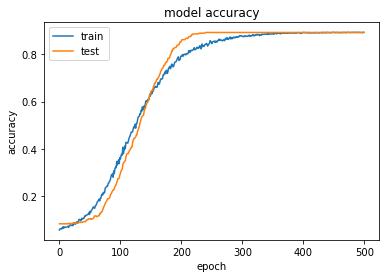

In [443]:
plt.plot(zillow_model.history['acc'])
plt.plot(zillow_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [122]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
business_model = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 1s 283us/step - loss: 2.0655 - acc: 0.2321 - val_loss: 1.1804 - val_acc: 0.7281
Epoch 2/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.1478 - acc: 0.6724 - val_loss: 1.0211 - val_acc: 0.7281
Epoch 3/500
2839/2839 [==============================] - 0s 27us/step - loss: 1.0414 - acc: 0.6759 - val_loss: 0.9872 - val_acc: 0.7281
Epoch 4/500
2839/2839 [==============================] - 0s 29us/step - loss: 1.0273 - acc: 0.6742 - val_loss: 0.9855 - val_acc: 0.7281
Epoch 5/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.0207 - acc: 0.6696 - val_loss: 0.9742 - val_acc: 0.7281
Epoch 6/500
2839/2839 [==============================] - 0s 31us/step - loss: 1.0106 - acc: 0.6714 - val_loss: 0.9559 - val_acc: 0.7281
Epoch 7/500
2839/2839 [==============================] - 0s 28us/step - loss: 1.0040 - acc: 0.6745 - val_loss: 0.9374 - val_acc: 0.7281


2839/2839 [==============================] - 0s 30us/step - loss: 0.8304 - acc: 0.7038 - val_loss: 0.8586 - val_acc: 0.7432
Epoch 61/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.8325 - acc: 0.6985 - val_loss: 0.9041 - val_acc: 0.7251
Epoch 62/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.8433 - acc: 0.6925 - val_loss: 0.8742 - val_acc: 0.7553
Epoch 63/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.8190 - acc: 0.7052 - val_loss: 0.8451 - val_acc: 0.7553
Epoch 64/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.8206 - acc: 0.7041 - val_loss: 0.8311 - val_acc: 0.7553
Epoch 65/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.8147 - acc: 0.7087 - val_loss: 0.8386 - val_acc: 0.7553
Epoch 66/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.8465 - acc: 0.6985 - val_loss: 0.8609 - val_acc: 0.7281
Epoch 67/500
2839/2839 [==============================

Epoch 120/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.7381 - acc: 0.7238 - val_loss: 0.8318 - val_acc: 0.7432
Epoch 121/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.7329 - acc: 0.7302 - val_loss: 0.8228 - val_acc: 0.7372
Epoch 122/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.7007 - acc: 0.7327 - val_loss: 0.8931 - val_acc: 0.7251
Epoch 123/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.7409 - acc: 0.7214 - val_loss: 0.8499 - val_acc: 0.7311
Epoch 124/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.7151 - acc: 0.7429 - val_loss: 0.8580 - val_acc: 0.7190
Epoch 125/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.7079 - acc: 0.7443 - val_loss: 0.8304 - val_acc: 0.7311
Epoch 126/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.6852 - acc: 0.7411 - val_loss: 0.8538 - val_acc: 0.7281
Epoch 127/500
2839/2839 [=========

2839/2839 [==============================] - 0s 28us/step - loss: 0.6635 - acc: 0.7390 - val_loss: 0.9807 - val_acc: 0.7009
Epoch 180/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.6177 - acc: 0.7615 - val_loss: 0.9605 - val_acc: 0.7009
Epoch 181/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.5941 - acc: 0.7644 - val_loss: 0.9577 - val_acc: 0.7100
Epoch 182/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.5830 - acc: 0.7820 - val_loss: 0.9727 - val_acc: 0.7130
Epoch 183/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.5903 - acc: 0.7791 - val_loss: 1.0679 - val_acc: 0.6979
Epoch 184/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.6412 - acc: 0.7443 - val_loss: 1.0551 - val_acc: 0.7130
Epoch 185/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.6787 - acc: 0.7281 - val_loss: 0.9429 - val_acc: 0.7190
Epoch 186/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 28us/step - loss: 0.5296 - acc: 0.7950 - val_loss: 1.0574 - val_acc: 0.6737
Epoch 239/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.5698 - acc: 0.7834 - val_loss: 1.0322 - val_acc: 0.6918
Epoch 240/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.5309 - acc: 0.8151 - val_loss: 1.0638 - val_acc: 0.6858
Epoch 241/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.5098 - acc: 0.8207 - val_loss: 1.1281 - val_acc: 0.6556
Epoch 242/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.5724 - acc: 0.7918 - val_loss: 1.0889 - val_acc: 0.6586
Epoch 243/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.5068 - acc: 0.8154 - val_loss: 1.0690 - val_acc: 0.6918
Epoch 244/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.5005 - acc: 0.8172 - val_loss: 1.0571 - val_acc: 0.6767
Epoch 245/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 29us/step - loss: 0.4764 - acc: 0.8214 - val_loss: 1.1709 - val_acc: 0.6647
Epoch 298/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.5081 - acc: 0.8006 - val_loss: 1.1402 - val_acc: 0.6888
Epoch 299/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.4573 - acc: 0.8323 - val_loss: 1.1875 - val_acc: 0.6767
Epoch 300/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.4254 - acc: 0.8450 - val_loss: 1.2353 - val_acc: 0.6858
Epoch 301/500
2839/2839 [==============================] - ETA: 0s - loss: 0.4208 - acc: 0.846 - 0s 29us/step - loss: 0.4301 - acc: 0.8426 - val_loss: 1.2196 - val_acc: 0.6918
Epoch 302/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.4522 - acc: 0.8369 - val_loss: 1.2700 - val_acc: 0.6979
Epoch 303/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.4526 - acc: 0.8211 - val_loss: 1.3799 - val_acc: 0.6918
Epoch 304/

2839/2839 [==============================] - 0s 30us/step - loss: 0.3926 - acc: 0.8612 - val_loss: 1.3849 - val_acc: 0.6707
Epoch 357/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.3755 - acc: 0.8580 - val_loss: 1.4609 - val_acc: 0.6647
Epoch 358/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.4201 - acc: 0.8359 - val_loss: 1.6013 - val_acc: 0.6888
Epoch 359/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.5502 - acc: 0.7872 - val_loss: 1.3329 - val_acc: 0.6828
Epoch 360/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.4223 - acc: 0.8292 - val_loss: 1.3468 - val_acc: 0.6888
Epoch 361/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.3706 - acc: 0.8640 - val_loss: 1.4088 - val_acc: 0.6677
Epoch 362/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.3648 - acc: 0.8644 - val_loss: 1.4083 - val_acc: 0.6798
Epoch 363/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 31us/step - loss: 0.3149 - acc: 0.8852 - val_loss: 1.5277 - val_acc: 0.6526
Epoch 416/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.3090 - acc: 0.8820 - val_loss: 1.5163 - val_acc: 0.6495
Epoch 417/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.3200 - acc: 0.8912 - val_loss: 1.5370 - val_acc: 0.6556
Epoch 418/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.3457 - acc: 0.8774 - val_loss: 1.5660 - val_acc: 0.6284
Epoch 419/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.3675 - acc: 0.8654 - val_loss: 1.5538 - val_acc: 0.6526
Epoch 420/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.3117 - acc: 0.8873 - val_loss: 1.7101 - val_acc: 0.6798
Epoch 421/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.3812 - acc: 0.8433 - val_loss: 1.7533 - val_acc: 0.6888
Epoch 422/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 31us/step - loss: 0.3089 - acc: 0.8947 - val_loss: 1.5605 - val_acc: 0.6435
Epoch 475/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.3505 - acc: 0.8662 - val_loss: 1.5701 - val_acc: 0.6586
Epoch 476/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.3714 - acc: 0.8514 - val_loss: 1.5625 - val_acc: 0.6707
Epoch 477/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.3171 - acc: 0.8859 - val_loss: 1.6753 - val_acc: 0.6888
Epoch 478/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.2864 - acc: 0.8926 - val_loss: 1.6597 - val_acc: 0.6586
Epoch 479/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.2712 - acc: 0.9038 - val_loss: 1.7270 - val_acc: 0.6707
Epoch 480/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.2700 - acc: 0.9003 - val_loss: 1.6959 - val_acc: 0.6616
Epoch 481/500
2839/2839 [=======================

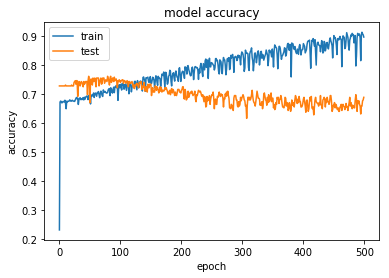

In [124]:
plt.plot(business_model.history['acc'])
plt.plot(business_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [363]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [364]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 2s 792us/step - loss: 1.7219 - acc: 0.4421 - val_loss: 1.5104 - val_acc: 0.4532
Epoch 2/500
2839/2839 [==============================] - 0s 73us/step - loss: 1.5249 - acc: 0.4540 - val_loss: 1.3789 - val_acc: 0.4653
Epoch 3/500
2839/2839 [==============================] - 0s 64us/step - loss: 1.3835 - acc: 0.4871 - val_loss: 1.3666 - val_acc: 0.4653
Epoch 4/500
2839/2839 [==============================] - 0s 62us/step - loss: 1.3781 - acc: 0.4762 - val_loss: 1.3491 - val_acc: 0.4653
Epoch 5/500
2839/2839 [==============================] - 0s 61us/step - loss: 1.3643 - acc: 0.4833 - val_loss: 1.3416 - val_acc: 0.4653
Epoch 6/500
2839/2839 [==============================] - 0s 61us/step - loss: 1.3404 - acc: 0.4815 - val_loss: 1.3416 - val_acc: 0.4653
Epoch 7/500
2839/2839 [==============================] - 0s 62us/step - loss: 1.3350 - acc: 0.4822 - val_loss: 1.3372 - val_acc: 0.4653


2839/2839 [==============================] - 0s 72us/step - loss: 1.1357 - acc: 0.5305 - val_loss: 1.3376 - val_acc: 0.4290
Epoch 61/500
2839/2839 [==============================] - 0s 73us/step - loss: 1.1398 - acc: 0.5428 - val_loss: 1.3216 - val_acc: 0.4532
Epoch 62/500
2839/2839 [==============================] - 0s 74us/step - loss: 1.1385 - acc: 0.5375 - val_loss: 1.4189 - val_acc: 0.4230
Epoch 63/500
2839/2839 [==============================] - 0s 73us/step - loss: 1.1598 - acc: 0.5301 - val_loss: 1.3308 - val_acc: 0.4743
Epoch 64/500
2839/2839 [==============================] - 0s 72us/step - loss: 1.1149 - acc: 0.5534 - val_loss: 1.3027 - val_acc: 0.4773
Epoch 65/500
2839/2839 [==============================] - 0s 74us/step - loss: 1.1056 - acc: 0.5495 - val_loss: 1.3274 - val_acc: 0.4864
Epoch 66/500
2839/2839 [==============================] - 0s 72us/step - loss: 1.1173 - acc: 0.5460 - val_loss: 1.4048 - val_acc: 0.4411
Epoch 67/500
2839/2839 [==============================

Epoch 120/500
2839/2839 [==============================] - 0s 70us/step - loss: 1.0734 - acc: 0.5766 - val_loss: 1.3216 - val_acc: 0.4683
Epoch 121/500
2839/2839 [==============================] - 0s 74us/step - loss: 1.0078 - acc: 0.5822 - val_loss: 1.2495 - val_acc: 0.4985
Epoch 122/500
2839/2839 [==============================] - 0s 73us/step - loss: 1.0208 - acc: 0.5773 - val_loss: 1.2429 - val_acc: 0.5438
Epoch 123/500
2839/2839 [==============================] - 0s 73us/step - loss: 1.0722 - acc: 0.5629 - val_loss: 1.2434 - val_acc: 0.5166
Epoch 124/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.9914 - acc: 0.5970 - val_loss: 1.2270 - val_acc: 0.5378
Epoch 125/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.9858 - acc: 0.6087 - val_loss: 1.2268 - val_acc: 0.5317
Epoch 126/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.9791 - acc: 0.6073 - val_loss: 1.2942 - val_acc: 0.5136
Epoch 127/500
2839/2839 [=========

2839/2839 [==============================] - 0s 65us/step - loss: 0.9281 - acc: 0.6245 - val_loss: 1.4810 - val_acc: 0.4411
Epoch 180/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.9409 - acc: 0.6210 - val_loss: 1.3085 - val_acc: 0.5196
Epoch 181/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.8275 - acc: 0.6766 - val_loss: 1.3472 - val_acc: 0.5076
Epoch 182/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.8474 - acc: 0.6742 - val_loss: 1.4064 - val_acc: 0.4834
Epoch 183/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.9546 - acc: 0.6256 - val_loss: 1.2886 - val_acc: 0.5196
Epoch 184/500
2839/2839 [==============================] - 0s 82us/step - loss: 0.8612 - acc: 0.6552 - val_loss: 1.3259 - val_acc: 0.5438
Epoch 185/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.8887 - acc: 0.6545 - val_loss: 1.3329 - val_acc: 0.5378
Epoch 186/500
2839/2839 [=======================

Epoch 238/500
2839/2839 [==============================] - 0s 69us/step - loss: 0.8595 - acc: 0.6520 - val_loss: 1.5766 - val_acc: 0.4804
Epoch 239/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.9101 - acc: 0.6390 - val_loss: 1.3913 - val_acc: 0.4985
Epoch 240/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.7480 - acc: 0.6978 - val_loss: 1.3964 - val_acc: 0.4894
Epoch 241/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.7358 - acc: 0.7115 - val_loss: 1.4776 - val_acc: 0.4985
Epoch 242/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.8076 - acc: 0.6770 - val_loss: 1.4728 - val_acc: 0.5106
Epoch 243/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.8722 - acc: 0.6506 - val_loss: 1.5141 - val_acc: 0.4622
Epoch 244/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.8346 - acc: 0.6576 - val_loss: 1.3805 - val_acc: 0.5166
Epoch 245/500
2839/2839 [=========

2839/2839 [==============================] - 0s 78us/step - loss: 0.6584 - acc: 0.7644 - val_loss: 1.5805 - val_acc: 0.4894
Epoch 298/500
2839/2839 [==============================] - 0s 81us/step - loss: 0.6826 - acc: 0.7425 - val_loss: 1.5945 - val_acc: 0.4924
Epoch 299/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.6926 - acc: 0.7260 - val_loss: 1.5123 - val_acc: 0.5106
Epoch 300/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.6725 - acc: 0.7274 - val_loss: 1.5861 - val_acc: 0.4894
Epoch 301/500
2839/2839 [==============================] - 0s 69us/step - loss: 0.7584 - acc: 0.6840 - val_loss: 1.6044 - val_acc: 0.4985
Epoch 302/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.7323 - acc: 0.7217 - val_loss: 1.6297 - val_acc: 0.4743
Epoch 303/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.7349 - acc: 0.7013 - val_loss: 1.5487 - val_acc: 0.5045
Epoch 304/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 76us/step - loss: 0.6950 - acc: 0.7231 - val_loss: 1.6389 - val_acc: 0.5076
Epoch 357/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.5915 - acc: 0.7636 - val_loss: 1.6580 - val_acc: 0.4864
Epoch 358/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.5797 - acc: 0.7781 - val_loss: 1.9001 - val_acc: 0.4955
Epoch 359/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.7588 - acc: 0.6918 - val_loss: 1.6310 - val_acc: 0.4713
Epoch 360/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.6257 - acc: 0.7594 - val_loss: 1.7265 - val_acc: 0.4773
Epoch 361/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.6029 - acc: 0.7672 - val_loss: 1.6615 - val_acc: 0.5076
Epoch 362/500
2839/2839 [==============================] - 0s 59us/step - loss: 0.5403 - acc: 0.7932 - val_loss: 1.6704 - val_acc: 0.5227
Epoch 363/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 70us/step - loss: 0.5967 - acc: 0.7665 - val_loss: 1.9016 - val_acc: 0.4320
Epoch 416/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.6605 - acc: 0.7425 - val_loss: 1.7537 - val_acc: 0.4985
Epoch 417/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.4732 - acc: 0.8401 - val_loss: 1.8367 - val_acc: 0.4834
Epoch 418/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.4874 - acc: 0.8108 - val_loss: 1.9274 - val_acc: 0.4683
Epoch 419/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.5656 - acc: 0.7696 - val_loss: 1.8502 - val_acc: 0.4622
Epoch 420/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.4666 - acc: 0.8369 - val_loss: 1.9370 - val_acc: 0.4471
Epoch 421/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.4872 - acc: 0.8179 - val_loss: 2.0769 - val_acc: 0.4290
Epoch 422/500
2839/2839 [=======================

2839/2839 [==============================] - 0s 73us/step - loss: 0.3885 - acc: 0.8665 - val_loss: 2.0613 - val_acc: 0.4502
Epoch 475/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.4339 - acc: 0.8383 - val_loss: 2.0401 - val_acc: 0.4532
Epoch 476/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.5068 - acc: 0.8080 - val_loss: 2.0342 - val_acc: 0.4924
Epoch 477/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.5033 - acc: 0.8073 - val_loss: 2.3026 - val_acc: 0.4864
Epoch 478/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.6542 - acc: 0.7267 - val_loss: 2.0380 - val_acc: 0.4834
Epoch 479/500
2839/2839 [==============================] - 0s 68us/step - loss: 0.5212 - acc: 0.7848 - val_loss: 1.9089 - val_acc: 0.4713
Epoch 480/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.4024 - acc: 0.8538 - val_loss: 2.0577 - val_acc: 0.4683
Epoch 481/500
2839/2839 [=======================

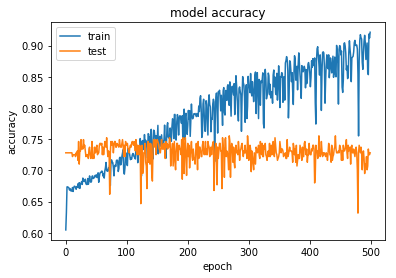

In [130]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [690]:
X_test_cat_mod_df_2.head()

,0,1,2,3,4,loss,gain,1,2,3,4,5,gain_true_true,gain_stay,loss_true_true,loss_stay,gain_large,loss_large,gain_large_true,loss_large_true
0,4.386394e-03,1.050091e-01,1.591386e-01,0.356899,3.745667e-01,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,2.575360e-10,2.015372e-06,9.907100e-01,0.009283,5.487662e-06,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
2,1.422529e-10,2.247291e-07,9.999537e-01,0.000046,4.702748e-07,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
3,2.420212e-11,1.134737e-06,1.622263e-06,0.083518,9.164789e-01,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
4,5.406993e-33,1.000000e+00,7.781700e-19,0.000000,0.000000e+00,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [697]:
len(X_test_cat_mod_df_2)

331

In [696]:
# Making sure there are no duplicates in predictions
one = X_test_cat_mod_df_2['1'].sum()
two = X_test_cat_mod_df_2['2'].sum()
three = X_test_cat_mod_df_2['3'].sum()
four = X_test_cat_mod_df_2['4'].sum()
five = X_test_cat_mod_df_2['5'].sum()
one + two + three + four + five

331

In [689]:
def model_metrics(predictions, y_test):
    df = pd.DataFrame(predictions)
    # predicting a loss 3% or larger by seeing if max loss probability is higher then slight gain
    df['loss'] = np.where(df[0] > df[3], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then slight loss
    df['gain'] = np.where(df[4] > df[1], 1, 0)
    df = pd.merge(df, y_test, left_index=True, right_index=True, how='inner')
    # predicting a loss 3% or larger by seeing if max loss probability is higher then mean probibility 
    df['loss_large'] = np.where(df[0] > df[2], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then mean probibility 
    df['gain_large'] = np.where(df[4] > df[2], 1, 0)
    # Cheching if loss is predicted and a loss of 3% or more occurs
    df['loss_true_true'] = np.where((df['loss'] == 1) & (df['2'] == 1) | (df['1'] == 1), 1, 0)
    # Checking if loss is predicted and price stays at the mean
    df['loss_stay'] = np.where((df['loss'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large loss is predicted and a loss of 3% or more occurs
    df['loss_large_true'] = np.where((df['loss_large'] == 1) & (df['2'] == 1) | (df['1'] == 1), 1, 0)
    # Cheching if large loss is predicted and price stays at the mean
    df['loss_large_stay'] = np.where((df['loss_large'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if gain is predicted and a loss of 3% or more occurs
    df['gain_true_true'] = np.where((df['gain'] == 1) & (df['4'] == 1) | (df['5'] == 1), 1, 0)
    # Checking if gain is predicted and price stays at the mean
    df['gain_stay'] = np.where((df['gain'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large gain is predicted and a gain of 3% or more occurs
    df['gain_large_true'] = np.where((df['gain_large'] == 1) & (df['4'] == 1) | (df['5'] == 1), 1, 0)
    # Cheching if large gain is predicted and price stays at the mean
    df['gain_large_stay'] = np.where((df['gain_large'] == 1) & (df['3'] == 1), 1, 0)
    #df['gain_large_large'] = np.where((df['gain_large'] == 1) & (df['5'] == 1), 1, 0)
    # Checking if both loss and gain are selected. This appears to mean high volitility
    df['volitile'] = np.where((df['loss'] == 1) & (df['gain'] == 1), 1, 0)
    
    
    gain_pred = df['gain'].sum()
    gain_large_pred = df['gain_large'].sum()
    gain_stay_true = (df['gain_true_true'].sum() + df['gain_stay'].sum()) / df['gain'].sum()
    gain_true = df['gain_true_true'].sum() / df['gain'].sum()
    loss_stay_true = (df['loss_true_true'].sum() + df['loss_stay'].sum()) / df['loss'].sum()
    loss_stay_true = df['loss_true_true'].sum() / df['loss'].sum()
    gain_stay_large_true = (df['gain_large_true'].sum() + df['gain_large_stay'].sum()) / df['gain_large'].sum()
    gain_large_true = df['gain_large_true'].sum() / df['gain_large'].sum()
    loss_stay_large_true = (df['loss_large_true'].sum() + df['loss_large_stay']) / df['loss_large'].sum()
    loss_large_true = df['loss_large_true'].sum() / df['loss_large'].sum()
    volitile = df['volitile'].sum()
    print(gain_pred)
    print(gain_true)
    print(gain_stay_true)
    print(gain_large_pred)
    print(gain_large_true)
    print(gain_stay_large_true)
    
    

In [677]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [678]:
zillow_model = model.fit(x=X_train, y=y_cat_train, 
          batch_size=20000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 3s 1ms/step - loss: 1.5620 - acc: 0.1828 - val_loss: 1.6732 - val_acc: 0.0665
Epoch 2/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.5574 - acc: 0.1832 - val_loss: 1.6712 - val_acc: 0.0665
Epoch 3/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.5727 - acc: 0.1775 - val_loss: 1.6697 - val_acc: 0.0665
Epoch 4/1000
2839/2839 [==============================] - 0s 23us/step - loss: 1.5649 - acc: 0.1892 - val_loss: 1.6682 - val_acc: 0.0665
Epoch 5/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5585 - acc: 0.1825 - val_loss: 1.6668 - val_acc: 0.0665
Epoch 6/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5694 - acc: 0.1744 - val_loss: 1.6657 - val_acc: 0.0665
Epoch 7/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5605 - acc: 0.1825 - val_loss: 1.6644 - val_acc: 0.

2839/2839 [==============================] - 0s 25us/step - loss: 1.5157 - acc: 0.2258 - val_loss: 1.6271 - val_acc: 0.0846
Epoch 61/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5290 - acc: 0.2039 - val_loss: 1.6265 - val_acc: 0.0846
Epoch 62/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.5104 - acc: 0.2135 - val_loss: 1.6260 - val_acc: 0.0846
Epoch 63/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5373 - acc: 0.1990 - val_loss: 1.6254 - val_acc: 0.0846
Epoch 64/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.5130 - acc: 0.2057 - val_loss: 1.6249 - val_acc: 0.0906
Epoch 65/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.5239 - acc: 0.2240 - val_loss: 1.6244 - val_acc: 0.0937
Epoch 66/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.5250 - acc: 0.2032 - val_loss: 1.6239 - val_acc: 0.1027
Epoch 67/1000
2839/2839 [=======================

Epoch 120/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4851 - acc: 0.2416 - val_loss: 1.5979 - val_acc: 0.2205
Epoch 121/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4924 - acc: 0.2452 - val_loss: 1.5975 - val_acc: 0.2175
Epoch 122/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4896 - acc: 0.2416 - val_loss: 1.5969 - val_acc: 0.2175
Epoch 123/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4845 - acc: 0.2430 - val_loss: 1.5965 - val_acc: 0.2236
Epoch 124/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4851 - acc: 0.2497 - val_loss: 1.5961 - val_acc: 0.2266
Epoch 125/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4854 - acc: 0.2430 - val_loss: 1.5957 - val_acc: 0.2326
Epoch 126/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4786 - acc: 0.2469 - val_loss: 1.5952 - val_acc: 0.2296
Epoch 127/1000
2839/2839 [=

Epoch 179/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4644 - acc: 0.2719 - val_loss: 1.5738 - val_acc: 0.3112
Epoch 180/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4503 - acc: 0.2874 - val_loss: 1.5734 - val_acc: 0.3112
Epoch 181/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4567 - acc: 0.2754 - val_loss: 1.5731 - val_acc: 0.3112
Epoch 182/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4581 - acc: 0.2769 - val_loss: 1.5727 - val_acc: 0.3112
Epoch 183/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.4572 - acc: 0.2702 - val_loss: 1.5724 - val_acc: 0.3112
Epoch 184/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4639 - acc: 0.2758 - val_loss: 1.5721 - val_acc: 0.3172
Epoch 185/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4575 - acc: 0.2709 - val_loss: 1.5719 - val_acc: 0.3172
Epoch 186/1000
2839/2839 [=

Epoch 238/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4338 - acc: 0.3086 - val_loss: 1.5525 - val_acc: 0.3323
Epoch 239/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4424 - acc: 0.2998 - val_loss: 1.5522 - val_acc: 0.3323
Epoch 240/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4206 - acc: 0.3019 - val_loss: 1.5520 - val_acc: 0.3323
Epoch 241/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4272 - acc: 0.3008 - val_loss: 1.5517 - val_acc: 0.3323
Epoch 242/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4313 - acc: 0.3012 - val_loss: 1.5513 - val_acc: 0.3323
Epoch 243/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.4187 - acc: 0.3110 - val_loss: 1.5509 - val_acc: 0.3323
Epoch 244/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4242 - acc: 0.3075 - val_loss: 1.5505 - val_acc: 0.3323
Epoch 245/1000
2839/2839 [=

Epoch 297/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4045 - acc: 0.3325 - val_loss: 1.5332 - val_acc: 0.3323
Epoch 298/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.4069 - acc: 0.3244 - val_loss: 1.5330 - val_acc: 0.3323
Epoch 299/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4084 - acc: 0.3093 - val_loss: 1.5329 - val_acc: 0.3323
Epoch 300/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4111 - acc: 0.3265 - val_loss: 1.5327 - val_acc: 0.3323
Epoch 301/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4120 - acc: 0.3167 - val_loss: 1.5324 - val_acc: 0.3323
Epoch 302/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4041 - acc: 0.3343 - val_loss: 1.5322 - val_acc: 0.3323
Epoch 303/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.4096 - acc: 0.3293 - val_loss: 1.5318 - val_acc: 0.3323
Epoch 304/1000
2839/2839 [=

Epoch 356/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3827 - acc: 0.3431 - val_loss: 1.5176 - val_acc: 0.3323
Epoch 357/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3984 - acc: 0.3378 - val_loss: 1.5173 - val_acc: 0.3323
Epoch 358/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3959 - acc: 0.3371 - val_loss: 1.5171 - val_acc: 0.3323
Epoch 359/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3826 - acc: 0.3385 - val_loss: 1.5168 - val_acc: 0.3323
Epoch 360/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3833 - acc: 0.3427 - val_loss: 1.5165 - val_acc: 0.3323
Epoch 361/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3818 - acc: 0.3466 - val_loss: 1.5163 - val_acc: 0.3323
Epoch 362/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3999 - acc: 0.3381 - val_loss: 1.5162 - val_acc: 0.3323
Epoch 363/1000
2839/2839 [=

Epoch 415/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3794 - acc: 0.3522 - val_loss: 1.5039 - val_acc: 0.3323
Epoch 416/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3742 - acc: 0.3554 - val_loss: 1.5036 - val_acc: 0.3323
Epoch 417/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3975 - acc: 0.3480 - val_loss: 1.5033 - val_acc: 0.3323
Epoch 418/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3670 - acc: 0.3568 - val_loss: 1.5031 - val_acc: 0.3323
Epoch 419/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3801 - acc: 0.3572 - val_loss: 1.5029 - val_acc: 0.3323
Epoch 420/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3724 - acc: 0.3565 - val_loss: 1.5028 - val_acc: 0.3323
Epoch 421/1000
2839/2839 [==============================] - 0s 29us/step - loss: 1.3646 - acc: 0.3579 - val_loss: 1.5026 - val_acc: 0.3323
Epoch 422/1000
2839/2839 [=

Epoch 474/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3608 - acc: 0.3734 - val_loss: 1.4927 - val_acc: 0.3323
Epoch 475/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3705 - acc: 0.3610 - val_loss: 1.4926 - val_acc: 0.3323
Epoch 476/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3673 - acc: 0.3533 - val_loss: 1.4925 - val_acc: 0.3323
Epoch 477/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3552 - acc: 0.3695 - val_loss: 1.4923 - val_acc: 0.3323
Epoch 478/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3775 - acc: 0.3470 - val_loss: 1.4922 - val_acc: 0.3323
Epoch 479/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3707 - acc: 0.3544 - val_loss: 1.4919 - val_acc: 0.3323
Epoch 480/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3730 - acc: 0.3593 - val_loss: 1.4918 - val_acc: 0.3323
Epoch 481/1000
2839/2839 [=

Epoch 533/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3547 - acc: 0.3734 - val_loss: 1.4835 - val_acc: 0.3323
Epoch 534/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3724 - acc: 0.3639 - val_loss: 1.4833 - val_acc: 0.3323
Epoch 535/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3675 - acc: 0.3649 - val_loss: 1.4833 - val_acc: 0.3323
Epoch 536/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3561 - acc: 0.3628 - val_loss: 1.4832 - val_acc: 0.3323
Epoch 537/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3657 - acc: 0.3614 - val_loss: 1.4830 - val_acc: 0.3323
Epoch 538/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3673 - acc: 0.3589 - val_loss: 1.4829 - val_acc: 0.3323
Epoch 539/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3603 - acc: 0.3607 - val_loss: 1.4827 - val_acc: 0.3323
Epoch 540/1000
2839/2839 [=

Epoch 592/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3461 - acc: 0.3779 - val_loss: 1.4752 - val_acc: 0.3323
Epoch 593/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3448 - acc: 0.3600 - val_loss: 1.4752 - val_acc: 0.3323
Epoch 594/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3406 - acc: 0.3787 - val_loss: 1.4750 - val_acc: 0.3323
Epoch 595/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3618 - acc: 0.3691 - val_loss: 1.4749 - val_acc: 0.3323
Epoch 596/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3686 - acc: 0.3653 - val_loss: 1.4748 - val_acc: 0.3323
Epoch 597/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3582 - acc: 0.3649 - val_loss: 1.4746 - val_acc: 0.3323
Epoch 598/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3483 - acc: 0.3649 - val_loss: 1.4746 - val_acc: 0.3323
Epoch 599/1000
2839/2839 [=

Epoch 651/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3517 - acc: 0.3625 - val_loss: 1.4684 - val_acc: 0.3323
Epoch 652/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.3505 - acc: 0.3772 - val_loss: 1.4683 - val_acc: 0.3323
Epoch 653/1000
2839/2839 [==============================] - 0s 33us/step - loss: 1.3475 - acc: 0.3758 - val_loss: 1.4683 - val_acc: 0.3323
Epoch 654/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.3568 - acc: 0.3660 - val_loss: 1.4682 - val_acc: 0.3323
Epoch 655/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3533 - acc: 0.3617 - val_loss: 1.4681 - val_acc: 0.3323
Epoch 656/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3416 - acc: 0.3836 - val_loss: 1.4680 - val_acc: 0.3323
Epoch 657/1000
2839/2839 [==============================] - 0s 33us/step - loss: 1.3401 - acc: 0.3762 - val_loss: 1.4678 - val_acc: 0.3323
Epoch 658/1000
2839/2839 [=

Epoch 710/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3411 - acc: 0.3642 - val_loss: 1.4620 - val_acc: 0.3323
Epoch 711/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3382 - acc: 0.3741 - val_loss: 1.4620 - val_acc: 0.3323
Epoch 712/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3419 - acc: 0.3758 - val_loss: 1.4618 - val_acc: 0.3323
Epoch 713/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3269 - acc: 0.3882 - val_loss: 1.4617 - val_acc: 0.3323
Epoch 714/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3458 - acc: 0.3702 - val_loss: 1.4617 - val_acc: 0.3323
Epoch 715/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3455 - acc: 0.3787 - val_loss: 1.4615 - val_acc: 0.3323
Epoch 716/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3313 - acc: 0.3850 - val_loss: 1.4614 - val_acc: 0.3323
Epoch 717/1000
2839/2839 [=

Epoch 769/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3316 - acc: 0.3794 - val_loss: 1.4562 - val_acc: 0.3323
Epoch 770/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3401 - acc: 0.3790 - val_loss: 1.4562 - val_acc: 0.3323
Epoch 771/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3349 - acc: 0.3751 - val_loss: 1.4562 - val_acc: 0.3323
Epoch 772/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3413 - acc: 0.3698 - val_loss: 1.4562 - val_acc: 0.3323
Epoch 773/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3299 - acc: 0.3804 - val_loss: 1.4560 - val_acc: 0.3323
Epoch 774/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3198 - acc: 0.3737 - val_loss: 1.4559 - val_acc: 0.3323
Epoch 775/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3371 - acc: 0.3628 - val_loss: 1.4558 - val_acc: 0.3323
Epoch 776/1000
2839/2839 [=

Epoch 828/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3259 - acc: 0.3783 - val_loss: 1.4516 - val_acc: 0.3323
Epoch 829/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3291 - acc: 0.3720 - val_loss: 1.4515 - val_acc: 0.3323
Epoch 830/1000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3187 - acc: 0.3861 - val_loss: 1.4514 - val_acc: 0.3323
Epoch 831/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3264 - acc: 0.3829 - val_loss: 1.4514 - val_acc: 0.3323
Epoch 832/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3289 - acc: 0.3741 - val_loss: 1.4513 - val_acc: 0.3323
Epoch 833/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3401 - acc: 0.3695 - val_loss: 1.4513 - val_acc: 0.3323
Epoch 834/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3290 - acc: 0.3691 - val_loss: 1.4514 - val_acc: 0.3323
Epoch 835/1000
2839/2839 [=

Epoch 887/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3083 - acc: 0.3868 - val_loss: 1.4479 - val_acc: 0.3323
Epoch 888/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3237 - acc: 0.3751 - val_loss: 1.4478 - val_acc: 0.3323
Epoch 889/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3068 - acc: 0.3832 - val_loss: 1.4477 - val_acc: 0.3323
Epoch 890/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3249 - acc: 0.3822 - val_loss: 1.4476 - val_acc: 0.3323
Epoch 891/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3212 - acc: 0.3899 - val_loss: 1.4476 - val_acc: 0.3323
Epoch 892/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3369 - acc: 0.3656 - val_loss: 1.4477 - val_acc: 0.3323
Epoch 893/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3414 - acc: 0.3741 - val_loss: 1.4478 - val_acc: 0.3323
Epoch 894/1000
2839/2839 [=

Epoch 946/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3160 - acc: 0.3832 - val_loss: 1.4448 - val_acc: 0.3323
Epoch 947/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3155 - acc: 0.3846 - val_loss: 1.4447 - val_acc: 0.3323
Epoch 948/1000
2839/2839 [==============================] - 0s 24us/step - loss: 1.3184 - acc: 0.3889 - val_loss: 1.4445 - val_acc: 0.3323
Epoch 949/1000
2839/2839 [==============================] - 0s 26us/step - loss: 1.3122 - acc: 0.3783 - val_loss: 1.4444 - val_acc: 0.3323
Epoch 950/1000
2839/2839 [==============================] - 0s 25us/step - loss: 1.3180 - acc: 0.3758 - val_loss: 1.4444 - val_acc: 0.3323
Epoch 951/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3177 - acc: 0.3885 - val_loss: 1.4444 - val_acc: 0.3323
Epoch 952/1000
2839/2839 [==============================] - 0s 27us/step - loss: 1.3178 - acc: 0.3815 - val_loss: 1.4443 - val_acc: 0.3323
Epoch 953/1000
2839/2839 [=

In [679]:
predictions = model.predict(X_test)
model_metrics(predictions, X_test, y_cat_test)

ZeroDivisionError: division by zero

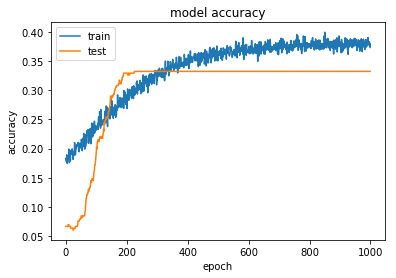

In [680]:
plt.plot(zillow_model.history['acc'])
plt.plot(zillow_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [681]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [682]:
business_model = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 4s 1ms/step - loss: 1.7115 - acc: 0.2015 - val_loss: 1.4891 - val_acc: 0.3323
Epoch 2/1000
2839/2839 [==============================] - 0s 35us/step - loss: 1.4305 - acc: 0.3269 - val_loss: 1.4700 - val_acc: 0.3323
Epoch 3/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.3943 - acc: 0.3603 - val_loss: 1.4461 - val_acc: 0.3323
Epoch 4/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.3899 - acc: 0.3364 - val_loss: 1.4939 - val_acc: 0.3323
Epoch 5/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.3655 - acc: 0.3575 - val_loss: 1.4586 - val_acc: 0.3323
Epoch 6/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.3419 - acc: 0.3660 - val_loss: 1.5016 - val_acc: 0.3323
Epoch 7/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.3497 - acc: 0.3639 - val_loss: 1.4938 - val_acc: 0.

2839/2839 [==============================] - 0s 35us/step - loss: 1.1104 - acc: 0.4635 - val_loss: 1.2309 - val_acc: 0.4471
Epoch 61/1000
2839/2839 [==============================] - 0s 33us/step - loss: 1.1042 - acc: 0.4618 - val_loss: 1.2745 - val_acc: 0.4441
Epoch 62/1000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1012 - acc: 0.4597 - val_loss: 1.2683 - val_acc: 0.4653
Epoch 63/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.0969 - acc: 0.4646 - val_loss: 1.3028 - val_acc: 0.4199
Epoch 64/1000
2839/2839 [==============================] - 0s 32us/step - loss: 1.0958 - acc: 0.4480 - val_loss: 1.3507 - val_acc: 0.3776
Epoch 65/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.1113 - acc: 0.4516 - val_loss: 1.2818 - val_acc: 0.4199
Epoch 66/1000
2839/2839 [==============================] - 0s 30us/step - loss: 1.0769 - acc: 0.4632 - val_loss: 1.2468 - val_acc: 0.4502
Epoch 67/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 33us/step - loss: 0.9579 - acc: 0.5005 - val_loss: 1.1309 - val_acc: 0.4985
Epoch 120/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.9681 - acc: 0.5136 - val_loss: 1.1704 - val_acc: 0.4773
Epoch 121/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.9568 - acc: 0.5227 - val_loss: 1.1592 - val_acc: 0.4743
Epoch 122/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.9829 - acc: 0.5146 - val_loss: 1.1425 - val_acc: 0.4804
Epoch 123/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.9339 - acc: 0.5231 - val_loss: 1.1294 - val_acc: 0.4924
Epoch 124/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.9482 - acc: 0.4963 - val_loss: 1.1095 - val_acc: 0.4955
Epoch 125/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.9722 - acc: 0.5245 - val_loss: 1.1298 - val_acc: 0.4864
Epoch 126/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.8429 - acc: 0.5414 - val_loss: 1.1790 - val_acc: 0.4864
Epoch 179/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.8349 - acc: 0.5576 - val_loss: 1.1491 - val_acc: 0.5045
Epoch 180/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8343 - acc: 0.5597 - val_loss: 1.1821 - val_acc: 0.4955
Epoch 181/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8612 - acc: 0.5379 - val_loss: 1.3030 - val_acc: 0.4441
Epoch 182/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.9193 - acc: 0.5118 - val_loss: 1.2922 - val_acc: 0.4109
Epoch 183/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8573 - acc: 0.5343 - val_loss: 1.2237 - val_acc: 0.4471
Epoch 184/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.8239 - acc: 0.5477 - val_loss: 1.2253 - val_acc: 0.4502
Epoch 185/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.7708 - acc: 0.5861 - val_loss: 1.2583 - val_acc: 0.4864
Epoch 238/1000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7425 - acc: 0.6013 - val_loss: 1.2220 - val_acc: 0.4985
Epoch 239/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7527 - acc: 0.5840 - val_loss: 1.2000 - val_acc: 0.5076
Epoch 240/1000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7745 - acc: 0.5896 - val_loss: 1.2092 - val_acc: 0.5076
Epoch 241/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7560 - acc: 0.6055 - val_loss: 1.3039 - val_acc: 0.4713
Epoch 242/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7482 - acc: 0.6069 - val_loss: 1.3142 - val_acc: 0.4381
Epoch 243/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7713 - acc: 0.5900 - val_loss: 1.3135 - val_acc: 0.4532
Epoch 244/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.6475 - acc: 0.6333 - val_loss: 1.3554 - val_acc: 0.4804
Epoch 297/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.6537 - acc: 0.6294 - val_loss: 1.2974 - val_acc: 0.4864
Epoch 298/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7067 - acc: 0.6058 - val_loss: 1.2744 - val_acc: 0.5015
Epoch 299/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6965 - acc: 0.6143 - val_loss: 1.3315 - val_acc: 0.5045
Epoch 300/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.6961 - acc: 0.6249 - val_loss: 1.3159 - val_acc: 0.5045
Epoch 301/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7536 - acc: 0.6231 - val_loss: 1.3719 - val_acc: 0.4713
Epoch 302/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6465 - acc: 0.6312 - val_loss: 1.3994 - val_acc: 0.4804
Epoch 303/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.6053 - acc: 0.6654 - val_loss: 1.4601 - val_acc: 0.4804
Epoch 356/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5873 - acc: 0.6619 - val_loss: 1.4641 - val_acc: 0.4955
Epoch 357/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.6137 - acc: 0.6474 - val_loss: 1.4120 - val_acc: 0.5166
Epoch 358/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.6424 - acc: 0.6351 - val_loss: 1.3969 - val_acc: 0.5076
Epoch 359/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.8014 - acc: 0.6009 - val_loss: 1.3836 - val_acc: 0.4773
Epoch 360/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6144 - acc: 0.6523 - val_loss: 1.3894 - val_acc: 0.4804
Epoch 361/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6086 - acc: 0.6499 - val_loss: 1.3846 - val_acc: 0.5166
Epoch 362/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.5801 - acc: 0.6766 - val_loss: 1.5636 - val_acc: 0.4592
Epoch 415/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6331 - acc: 0.6668 - val_loss: 1.4874 - val_acc: 0.4743
Epoch 416/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.6134 - acc: 0.6833 - val_loss: 1.4811 - val_acc: 0.5045
Epoch 417/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5585 - acc: 0.6943 - val_loss: 1.4803 - val_acc: 0.5076
Epoch 418/1000
2839/2839 [==============================] - 0s 29us/step - loss: 0.5466 - acc: 0.6847 - val_loss: 1.4540 - val_acc: 0.5106
Epoch 419/1000
2839/2839 [==============================] - 0s 29us/step - loss: 0.5581 - acc: 0.6795 - val_loss: 1.4814 - val_acc: 0.4924
Epoch 420/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5830 - acc: 0.6538 - val_loss: 1.5353 - val_acc: 0.4683
Epoch 421/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.5433 - acc: 0.6777 - val_loss: 1.6405 - val_acc: 0.4683
Epoch 474/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4943 - acc: 0.7006 - val_loss: 1.6028 - val_acc: 0.4924
Epoch 475/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4737 - acc: 0.7150 - val_loss: 1.6888 - val_acc: 0.4441
Epoch 476/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4947 - acc: 0.6971 - val_loss: 1.6326 - val_acc: 0.4773
Epoch 477/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.5084 - acc: 0.6890 - val_loss: 1.6237 - val_acc: 0.4683
Epoch 478/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.5298 - acc: 0.6946 - val_loss: 1.5788 - val_acc: 0.4804
Epoch 479/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.5413 - acc: 0.6728 - val_loss: 1.5200 - val_acc: 0.5136
Epoch 480/1000
2839/2839 [================

2839/2839 [==============================] - 0s 33us/step - loss: 0.4945 - acc: 0.7242 - val_loss: 1.8963 - val_acc: 0.4018
Epoch 533/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.5089 - acc: 0.7129 - val_loss: 1.7367 - val_acc: 0.4592
Epoch 534/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4849 - acc: 0.7316 - val_loss: 1.6744 - val_acc: 0.4985
Epoch 535/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.4906 - acc: 0.7305 - val_loss: 1.6553 - val_acc: 0.5015
Epoch 536/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.5353 - acc: 0.7179 - val_loss: 1.6494 - val_acc: 0.4955
Epoch 537/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4579 - acc: 0.7443 - val_loss: 1.6896 - val_acc: 0.4894
Epoch 538/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4527 - acc: 0.7323 - val_loss: 1.7219 - val_acc: 0.4804
Epoch 539/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.4250 - acc: 0.7721 - val_loss: 1.9475 - val_acc: 0.4199
Epoch 592/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4548 - acc: 0.7432 - val_loss: 1.8348 - val_acc: 0.4562
Epoch 593/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4601 - acc: 0.7383 - val_loss: 1.9615 - val_acc: 0.4109
Epoch 594/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4804 - acc: 0.7157 - val_loss: 1.8590 - val_acc: 0.4532
Epoch 595/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4217 - acc: 0.7591 - val_loss: 1.8366 - val_acc: 0.4804
Epoch 596/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4122 - acc: 0.7510 - val_loss: 1.8424 - val_acc: 0.4743
Epoch 597/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4307 - acc: 0.7408 - val_loss: 1.8389 - val_acc: 0.4743
Epoch 598/1000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.4329 - acc: 0.7520 - val_loss: 1.9858 - val_acc: 0.4290
Epoch 651/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4398 - acc: 0.7545 - val_loss: 1.9499 - val_acc: 0.4532
Epoch 652/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4710 - acc: 0.7284 - val_loss: 1.9158 - val_acc: 0.4471
Epoch 653/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4057 - acc: 0.7580 - val_loss: 1.9298 - val_acc: 0.4773
Epoch 654/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3915 - acc: 0.7696 - val_loss: 1.9198 - val_acc: 0.4955
Epoch 655/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.3836 - acc: 0.7760 - val_loss: 1.8749 - val_acc: 0.4804
Epoch 656/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3877 - acc: 0.7732 - val_loss: 1.8555 - val_acc: 0.4743
Epoch 657/1000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.4033 - acc: 0.7496 - val_loss: 1.9410 - val_acc: 0.4894
Epoch 710/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3777 - acc: 0.7686 - val_loss: 1.9849 - val_acc: 0.5076
Epoch 711/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3654 - acc: 0.7788 - val_loss: 1.9893 - val_acc: 0.4894
Epoch 712/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3694 - acc: 0.7872 - val_loss: 2.0011 - val_acc: 0.4804
Epoch 713/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4229 - acc: 0.7393 - val_loss: 1.9843 - val_acc: 0.5015
Epoch 714/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.4464 - acc: 0.7175 - val_loss: 1.9368 - val_acc: 0.4955
Epoch 715/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3671 - acc: 0.7809 - val_loss: 1.9724 - val_acc: 0.4773
Epoch 716/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.3420 - acc: 0.8010 - val_loss: 2.1939 - val_acc: 0.4562
Epoch 769/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3459 - acc: 0.7957 - val_loss: 2.1677 - val_acc: 0.4562
Epoch 770/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3670 - acc: 0.7806 - val_loss: 2.3022 - val_acc: 0.4199
Epoch 771/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6061 - acc: 0.6974 - val_loss: 2.1141 - val_acc: 0.4411
Epoch 772/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.4148 - acc: 0.7580 - val_loss: 2.0822 - val_acc: 0.4713
Epoch 773/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3389 - acc: 0.8066 - val_loss: 2.0839 - val_acc: 0.4743
Epoch 774/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3311 - acc: 0.7999 - val_loss: 2.1447 - val_acc: 0.4804
Epoch 775/1000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.3272 - acc: 0.8087 - val_loss: 2.2230 - val_acc: 0.4804
Epoch 828/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3165 - acc: 0.8087 - val_loss: 2.2974 - val_acc: 0.4804
Epoch 829/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3110 - acc: 0.8112 - val_loss: 2.2524 - val_acc: 0.4804
Epoch 830/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3183 - acc: 0.8087 - val_loss: 2.3692 - val_acc: 0.4562
Epoch 831/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3819 - acc: 0.7876 - val_loss: 2.4692 - val_acc: 0.4350
Epoch 832/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4227 - acc: 0.7718 - val_loss: 2.3092 - val_acc: 0.4562
Epoch 833/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3953 - acc: 0.7880 - val_loss: 2.2214 - val_acc: 0.4985
Epoch 834/1000
2839/2839 [================

2839/2839 [==============================] - 0s 33us/step - loss: 0.2788 - acc: 0.8341 - val_loss: 2.3996 - val_acc: 0.4683
Epoch 887/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3649 - acc: 0.8080 - val_loss: 2.6819 - val_acc: 0.3716
Epoch 888/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6061 - acc: 0.6897 - val_loss: 2.2154 - val_acc: 0.4773
Epoch 889/1000
2839/2839 [==============================] - 0s 31us/step - loss: 0.3243 - acc: 0.8112 - val_loss: 2.2633 - val_acc: 0.4804
Epoch 890/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3066 - acc: 0.8179 - val_loss: 2.3237 - val_acc: 0.4773
Epoch 891/1000
2839/2839 [==============================] - 0s 33us/step - loss: 0.3012 - acc: 0.8186 - val_loss: 2.3238 - val_acc: 0.4924
Epoch 892/1000
2839/2839 [==============================] - 0s 42us/step - loss: 0.3298 - acc: 0.8091 - val_loss: 2.2825 - val_acc: 0.4713
Epoch 893/1000
2839/2839 [================

2839/2839 [==============================] - 0s 33us/step - loss: 0.2848 - acc: 0.8468 - val_loss: 2.5077 - val_acc: 0.4955
Epoch 946/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.2925 - acc: 0.8327 - val_loss: 2.4711 - val_acc: 0.4713
Epoch 947/1000
2839/2839 [==============================] - 0s 34us/step - loss: 0.3000 - acc: 0.8369 - val_loss: 2.5158 - val_acc: 0.4562
Epoch 948/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.2871 - acc: 0.8394 - val_loss: 2.6064 - val_acc: 0.4502
Epoch 949/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3129 - acc: 0.8267 - val_loss: 2.5931 - val_acc: 0.4290
Epoch 950/1000
2839/2839 [==============================] - 0s 32us/step - loss: 0.3118 - acc: 0.8344 - val_loss: 2.4536 - val_acc: 0.4683
Epoch 951/1000
2839/2839 [==============================] - 0s 30us/step - loss: 0.2772 - acc: 0.8394 - val_loss: 2.5020 - val_acc: 0.4743
Epoch 952/1000
2839/2839 [================

In [683]:
predictions = model.predict(X_test_business)
model_metrics(predictions, X_test_business, y_cat_test_business)

85
0.7647058823529411
1.0
46
0.9782608695652174
1.1956521739130435


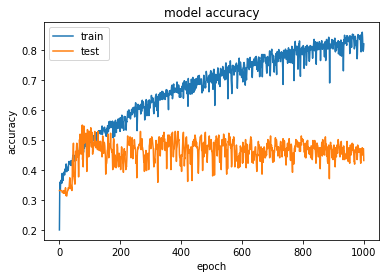

In [684]:
plt.plot(business_model.history['acc'])
plt.plot(business_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [685]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [686]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 4s 1ms/step - loss: 1.6095 - acc: 0.2867 - val_loss: 1.3737 - val_acc: 0.4169
Epoch 2/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.3743 - acc: 0.3698 - val_loss: 1.4394 - val_acc: 0.3323
Epoch 3/1000
2839/2839 [==============================] - 0s 69us/step - loss: 1.3419 - acc: 0.3670 - val_loss: 1.3779 - val_acc: 0.3384
Epoch 4/1000
2839/2839 [==============================] - 0s 68us/step - loss: 1.3302 - acc: 0.3790 - val_loss: 1.3915 - val_acc: 0.3323
Epoch 5/1000
2839/2839 [==============================] - 0s 65us/step - loss: 1.3208 - acc: 0.3617 - val_loss: 1.3997 - val_acc: 0.3353
Epoch 6/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.3079 - acc: 0.3494 - val_loss: 1.3805 - val_acc: 0.3384
Epoch 7/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.2969 - acc: 0.3772 - val_loss: 1.3599 - val_acc: 0.

2839/2839 [==============================] - 0s 61us/step - loss: 1.1038 - acc: 0.4283 - val_loss: 1.4281 - val_acc: 0.3142
Epoch 61/1000
2839/2839 [==============================] - 0s 61us/step - loss: 1.1114 - acc: 0.4195 - val_loss: 1.3091 - val_acc: 0.3263
Epoch 62/1000
2839/2839 [==============================] - 0s 61us/step - loss: 1.0870 - acc: 0.4308 - val_loss: 1.2975 - val_acc: 0.3263
Epoch 63/1000
2839/2839 [==============================] - 0s 62us/step - loss: 1.0692 - acc: 0.4375 - val_loss: 1.2518 - val_acc: 0.3353
Epoch 64/1000
2839/2839 [==============================] - 0s 61us/step - loss: 1.1391 - acc: 0.4153 - val_loss: 1.2227 - val_acc: 0.3565
Epoch 65/1000
2839/2839 [==============================] - 0s 62us/step - loss: 1.1107 - acc: 0.4435 - val_loss: 1.3233 - val_acc: 0.3172
Epoch 66/1000
2839/2839 [==============================] - 0s 61us/step - loss: 1.0616 - acc: 0.4336 - val_loss: 1.4124 - val_acc: 0.3202
Epoch 67/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 63us/step - loss: 0.9625 - acc: 0.4706 - val_loss: 1.2775 - val_acc: 0.4018
Epoch 120/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9520 - acc: 0.4671 - val_loss: 1.3358 - val_acc: 0.3776
Epoch 121/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9816 - acc: 0.4621 - val_loss: 1.2700 - val_acc: 0.3686
Epoch 122/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9936 - acc: 0.4576 - val_loss: 1.1799 - val_acc: 0.4320
Epoch 123/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.0116 - acc: 0.4688 - val_loss: 1.2116 - val_acc: 0.4320
Epoch 124/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9595 - acc: 0.4738 - val_loss: 1.1826 - val_acc: 0.4471
Epoch 125/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9841 - acc: 0.4812 - val_loss: 1.1571 - val_acc: 0.4924
Epoch 126/1000
2839/2839 [================

2839/2839 [==============================] - 0s 64us/step - loss: 0.9553 - acc: 0.4991 - val_loss: 1.2558 - val_acc: 0.4169
Epoch 179/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.8731 - acc: 0.4998 - val_loss: 1.2019 - val_acc: 0.4411
Epoch 180/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.8718 - acc: 0.5245 - val_loss: 1.1670 - val_acc: 0.4502
Epoch 181/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9013 - acc: 0.5150 - val_loss: 1.1683 - val_acc: 0.4411
Epoch 182/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.9031 - acc: 0.5379 - val_loss: 1.2326 - val_acc: 0.4441
Epoch 183/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.8574 - acc: 0.5301 - val_loss: 1.3001 - val_acc: 0.4139
Epoch 184/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.9622 - acc: 0.4871 - val_loss: 1.3410 - val_acc: 0.4230
Epoch 185/1000
2839/2839 [================

2839/2839 [==============================] - 0s 65us/step - loss: 0.8092 - acc: 0.5375 - val_loss: 1.3831 - val_acc: 0.4109
Epoch 238/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.8186 - acc: 0.5604 - val_loss: 1.3686 - val_acc: 0.4169
Epoch 239/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7975 - acc: 0.5678 - val_loss: 1.3526 - val_acc: 0.4411
Epoch 240/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7869 - acc: 0.5622 - val_loss: 1.4301 - val_acc: 0.4139
Epoch 241/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.8158 - acc: 0.5428 - val_loss: 1.3690 - val_acc: 0.4139
Epoch 242/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.7882 - acc: 0.5551 - val_loss: 1.4523 - val_acc: 0.3927
Epoch 243/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.8643 - acc: 0.5241 - val_loss: 1.3259 - val_acc: 0.4290
Epoch 244/1000
2839/2839 [================

2839/2839 [==============================] - 0s 64us/step - loss: 0.7326 - acc: 0.6073 - val_loss: 1.3806 - val_acc: 0.4350
Epoch 297/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7193 - acc: 0.6030 - val_loss: 1.4100 - val_acc: 0.4290
Epoch 298/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7424 - acc: 0.5861 - val_loss: 1.4761 - val_acc: 0.3807
Epoch 299/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7741 - acc: 0.5675 - val_loss: 1.4872 - val_acc: 0.3897
Epoch 300/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.8174 - acc: 0.5463 - val_loss: 1.3854 - val_acc: 0.4260
Epoch 301/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7524 - acc: 0.5555 - val_loss: 1.3740 - val_acc: 0.4441
Epoch 302/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7023 - acc: 0.6087 - val_loss: 1.4722 - val_acc: 0.3927
Epoch 303/1000
2839/2839 [================

2839/2839 [==============================] - 0s 63us/step - loss: 0.6771 - acc: 0.6330 - val_loss: 1.5494 - val_acc: 0.4018
Epoch 356/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7458 - acc: 0.6101 - val_loss: 1.3852 - val_acc: 0.4532
Epoch 357/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6468 - acc: 0.6347 - val_loss: 1.3573 - val_acc: 0.4985
Epoch 358/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.6902 - acc: 0.6087 - val_loss: 1.3773 - val_acc: 0.4743
Epoch 359/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7465 - acc: 0.6048 - val_loss: 1.3282 - val_acc: 0.4985
Epoch 360/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6368 - acc: 0.6499 - val_loss: 1.3672 - val_acc: 0.4985
Epoch 361/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6226 - acc: 0.6449 - val_loss: 1.4397 - val_acc: 0.4804
Epoch 362/1000
2839/2839 [================

2839/2839 [==============================] - 0s 64us/step - loss: 0.6094 - acc: 0.6323 - val_loss: 1.4477 - val_acc: 0.5045
Epoch 415/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6190 - acc: 0.6354 - val_loss: 1.4223 - val_acc: 0.5076
Epoch 416/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5746 - acc: 0.6671 - val_loss: 1.4955 - val_acc: 0.5196
Epoch 417/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.5589 - acc: 0.6710 - val_loss: 1.5380 - val_acc: 0.4924
Epoch 418/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6468 - acc: 0.6474 - val_loss: 1.5824 - val_acc: 0.4773
Epoch 419/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7233 - acc: 0.6323 - val_loss: 1.4651 - val_acc: 0.5015
Epoch 420/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5655 - acc: 0.6798 - val_loss: 1.5206 - val_acc: 0.5076
Epoch 421/1000
2839/2839 [================

2839/2839 [==============================] - 0s 64us/step - loss: 0.6496 - acc: 0.6273 - val_loss: 1.5808 - val_acc: 0.5106
Epoch 474/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5677 - acc: 0.6661 - val_loss: 1.5585 - val_acc: 0.5196
Epoch 475/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5650 - acc: 0.6830 - val_loss: 1.5509 - val_acc: 0.5287
Epoch 476/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6228 - acc: 0.6777 - val_loss: 1.5408 - val_acc: 0.5076
Epoch 477/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5594 - acc: 0.6872 - val_loss: 1.5671 - val_acc: 0.4894
Epoch 478/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.4906 - acc: 0.7076 - val_loss: 1.6260 - val_acc: 0.4592
Epoch 479/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5067 - acc: 0.6872 - val_loss: 1.6250 - val_acc: 0.4894
Epoch 480/1000
2839/2839 [================

2839/2839 [==============================] - 0s 66us/step - loss: 0.5021 - acc: 0.6844 - val_loss: 1.8103 - val_acc: 0.4471
Epoch 533/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.5111 - acc: 0.6749 - val_loss: 1.7723 - val_acc: 0.4320
Epoch 534/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.5906 - acc: 0.6671 - val_loss: 2.0278 - val_acc: 0.3656
Epoch 535/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.6243 - acc: 0.6478 - val_loss: 1.7971 - val_acc: 0.4350
Epoch 536/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.5288 - acc: 0.6978 - val_loss: 1.7390 - val_acc: 0.4834
Epoch 537/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.4806 - acc: 0.7295 - val_loss: 1.7648 - val_acc: 0.4924
Epoch 538/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.4946 - acc: 0.7203 - val_loss: 1.7461 - val_acc: 0.5136
Epoch 539/1000
2839/2839 [================

2839/2839 [==============================] - 0s 73us/step - loss: 0.5366 - acc: 0.6999 - val_loss: 1.8248 - val_acc: 0.5136
Epoch 592/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4166 - acc: 0.7520 - val_loss: 1.8896 - val_acc: 0.5196
Epoch 593/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.4053 - acc: 0.7524 - val_loss: 1.9565 - val_acc: 0.4773
Epoch 594/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.3999 - acc: 0.7471 - val_loss: 1.9190 - val_acc: 0.4773
Epoch 595/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.5125 - acc: 0.6960 - val_loss: 1.8861 - val_acc: 0.4471
Epoch 596/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.6735 - acc: 0.6252 - val_loss: 1.7973 - val_acc: 0.4804
Epoch 597/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.5067 - acc: 0.7147 - val_loss: 1.8899 - val_acc: 0.4743
Epoch 598/1000
2839/2839 [================

Epoch 650/1000
2839/2839 [==============================] - 0s 69us/step - loss: 0.4425 - acc: 0.7510 - val_loss: 2.0066 - val_acc: 0.4622
Epoch 651/1000
2839/2839 [==============================] - 0s 69us/step - loss: 0.4856 - acc: 0.7281 - val_loss: 1.9491 - val_acc: 0.5015
Epoch 652/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4142 - acc: 0.7654 - val_loss: 2.2176 - val_acc: 0.4169
Epoch 653/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.4718 - acc: 0.7319 - val_loss: 2.0591 - val_acc: 0.4169
Epoch 654/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4257 - acc: 0.7355 - val_loss: 1.9677 - val_acc: 0.5166
Epoch 655/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3972 - acc: 0.7654 - val_loss: 1.9789 - val_acc: 0.4955
Epoch 656/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.4612 - acc: 0.7425 - val_loss: 2.1144 - val_acc: 0.4260
Epoch 657/1000
2839/2839 [=

Epoch 709/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.3826 - acc: 0.7689 - val_loss: 2.0659 - val_acc: 0.5166
Epoch 710/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3409 - acc: 0.7964 - val_loss: 2.1115 - val_acc: 0.5196
Epoch 711/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.3459 - acc: 0.7957 - val_loss: 2.1052 - val_acc: 0.5529
Epoch 712/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3985 - acc: 0.7760 - val_loss: 2.0719 - val_acc: 0.5408
Epoch 713/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4412 - acc: 0.7633 - val_loss: 2.2358 - val_acc: 0.4894
Epoch 714/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.6904 - acc: 0.7098 - val_loss: 2.0404 - val_acc: 0.4834
Epoch 715/1000
2839/2839 [==============================] - 0s 60us/step - loss: 0.4437 - acc: 0.7651 - val_loss: 1.9577 - val_acc: 0.5166
Epoch 716/1000
2839/2839 [=

Epoch 768/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3204 - acc: 0.7925 - val_loss: 2.1482 - val_acc: 0.5347
Epoch 769/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.2903 - acc: 0.8175 - val_loss: 2.2007 - val_acc: 0.5106
Epoch 770/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3278 - acc: 0.7985 - val_loss: 2.1130 - val_acc: 0.5106
Epoch 771/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.3973 - acc: 0.7605 - val_loss: 2.2324 - val_acc: 0.4320
Epoch 772/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.4435 - acc: 0.7210 - val_loss: 2.0426 - val_acc: 0.5438
Epoch 773/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3333 - acc: 0.7957 - val_loss: 2.2279 - val_acc: 0.5106
Epoch 774/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3227 - acc: 0.8098 - val_loss: 2.1642 - val_acc: 0.5347
Epoch 775/1000
2839/2839 [=

Epoch 827/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5324 - acc: 0.6907 - val_loss: 2.3332 - val_acc: 0.4169
Epoch 828/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5169 - acc: 0.7182 - val_loss: 2.2987 - val_acc: 0.4411
Epoch 829/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3652 - acc: 0.8003 - val_loss: 2.2277 - val_acc: 0.4834
Epoch 830/1000
2839/2839 [==============================] - 0s 58us/step - loss: 0.3115 - acc: 0.8242 - val_loss: 2.2814 - val_acc: 0.4955
Epoch 831/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3128 - acc: 0.8204 - val_loss: 2.3562 - val_acc: 0.4773
Epoch 832/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3016 - acc: 0.8288 - val_loss: 2.3784 - val_acc: 0.4713
Epoch 833/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.2971 - acc: 0.8359 - val_loss: 2.4154 - val_acc: 0.4894
Epoch 834/1000
2839/2839 [=

Epoch 886/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.2739 - acc: 0.8316 - val_loss: 2.4017 - val_acc: 0.5227
Epoch 887/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.2685 - acc: 0.8454 - val_loss: 2.3868 - val_acc: 0.5378
Epoch 888/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.2866 - acc: 0.8380 - val_loss: 2.3762 - val_acc: 0.5166
Epoch 889/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3931 - acc: 0.7661 - val_loss: 2.4300 - val_acc: 0.4804
Epoch 890/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.4850 - acc: 0.7105 - val_loss: 2.2035 - val_acc: 0.5136
Epoch 891/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3701 - acc: 0.7872 - val_loss: 2.3249 - val_acc: 0.5136
Epoch 892/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.2725 - acc: 0.8457 - val_loss: 2.4792 - val_acc: 0.4985
Epoch 893/1000
2839/2839 [=

Epoch 945/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.4484 - acc: 0.7242 - val_loss: 2.3782 - val_acc: 0.5045
Epoch 946/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.2820 - acc: 0.8348 - val_loss: 2.4666 - val_acc: 0.5015
Epoch 947/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.2865 - acc: 0.8390 - val_loss: 2.5303 - val_acc: 0.4985
Epoch 948/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.2745 - acc: 0.8559 - val_loss: 2.6282 - val_acc: 0.4653
Epoch 949/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3151 - acc: 0.8362 - val_loss: 2.9489 - val_acc: 0.4018
Epoch 950/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.4467 - acc: 0.7700 - val_loss: 2.8006 - val_acc: 0.3837
Epoch 951/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.4232 - acc: 0.7728 - val_loss: 2.4606 - val_acc: 0.4773
Epoch 952/1000
2839/2839 [=

In [687]:
predictions = model.predict(X_test_w2v)
model_metrics(predictions, X_test_w2v, y_cat_test_w2v)

61
0.9180327868852459
1.0819672131147542
18
1.5
1.7777777777777777


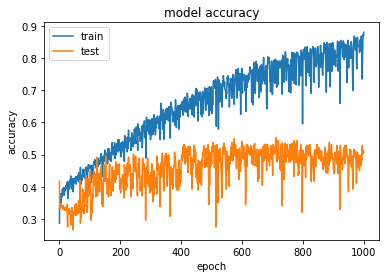

In [688]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

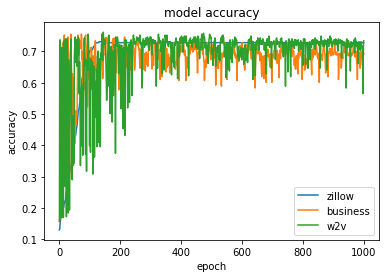

In [153]:
plt.plot(zillow_model.history['val_acc'])
plt.plot(business_model.history['val_acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['zillow', 'business', 'w2v'], loc='lower right')
plt.show()

In [394]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.4))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [395]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 2s 862us/step - loss: 1.1259 - acc: 0.1254 - val_loss: 1.9368 - val_acc: 0.1601
Epoch 2/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.1175 - acc: 0.1909 - val_loss: 1.9460 - val_acc: 0.1601
Epoch 3/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0942 - acc: 0.1997 - val_loss: 1.8857 - val_acc: 0.1601
Epoch 4/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0813 - acc: 0.2149 - val_loss: 1.7835 - val_acc: 0.1601
Epoch 5/1000
2839/2839 [==============================] - 0s 63us/step - loss: 1.0766 - acc: 0.2233 - val_loss: 1.7950 - val_acc: 0.1601
Epoch 6/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0503 - acc: 0.2261 - val_loss: 1.7223 - val_acc: 0.1601
Epoch 7/1000
2839/2839 [==============================] - 0s 64us/step - loss: 1.0509 - acc: 0.2279 - val_loss: 1.6586 - val_acc: 

2839/2839 [==============================] - 0s 74us/step - loss: 0.9216 - acc: 0.2990 - val_loss: 1.4096 - val_acc: 0.3112
Epoch 61/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.9407 - acc: 0.2839 - val_loss: 1.4566 - val_acc: 0.1873
Epoch 62/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.9277 - acc: 0.2747 - val_loss: 1.4364 - val_acc: 0.2931
Epoch 63/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.9177 - acc: 0.3054 - val_loss: 1.4107 - val_acc: 0.3082
Epoch 64/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.9259 - acc: 0.2959 - val_loss: 1.4824 - val_acc: 0.3595
Epoch 65/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.9149 - acc: 0.2934 - val_loss: 1.5134 - val_acc: 0.2115
Epoch 66/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.9199 - acc: 0.2920 - val_loss: 1.6228 - val_acc: 0.2296
Epoch 67/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 65us/step - loss: 0.8636 - acc: 0.3149 - val_loss: 1.4710 - val_acc: 0.3293
Epoch 120/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.8552 - acc: 0.3420 - val_loss: 1.4579 - val_acc: 0.3414
Epoch 121/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.9083 - acc: 0.3308 - val_loss: 1.4489 - val_acc: 0.2840
Epoch 122/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.8591 - acc: 0.3061 - val_loss: 1.4250 - val_acc: 0.3776
Epoch 123/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.8610 - acc: 0.3212 - val_loss: 1.4169 - val_acc: 0.3897
Epoch 124/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.8369 - acc: 0.3515 - val_loss: 1.4557 - val_acc: 0.3414
Epoch 125/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.8428 - acc: 0.3470 - val_loss: 1.4852 - val_acc: 0.3112
Epoch 126/1000
2839/2839 [================

2839/2839 [==============================] - 0s 84us/step - loss: 0.7772 - acc: 0.3540 - val_loss: 1.6051 - val_acc: 0.2508
Epoch 179/1000
2839/2839 [==============================] - 0s 82us/step - loss: 0.8090 - acc: 0.3262 - val_loss: 1.6834 - val_acc: 0.2296
Epoch 180/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.8153 - acc: 0.3293 - val_loss: 1.6268 - val_acc: 0.2447
Epoch 181/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.7980 - acc: 0.3272 - val_loss: 1.5503 - val_acc: 0.2900
Epoch 182/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.7672 - acc: 0.3709 - val_loss: 1.6704 - val_acc: 0.2266
Epoch 183/1000
2839/2839 [==============================] - 0s 87us/step - loss: 0.8060 - acc: 0.3184 - val_loss: 1.5536 - val_acc: 0.2900
Epoch 184/1000
2839/2839 [==============================] - 0s 84us/step - loss: 0.7750 - acc: 0.3617 - val_loss: 1.5546 - val_acc: 0.2870
Epoch 185/1000
2839/2839 [================

2839/2839 [==============================] - 0s 73us/step - loss: 0.7154 - acc: 0.3783 - val_loss: 1.5555 - val_acc: 0.3233
Epoch 238/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.7267 - acc: 0.3617 - val_loss: 1.4729 - val_acc: 0.3746
Epoch 239/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.6975 - acc: 0.4019 - val_loss: 1.5899 - val_acc: 0.3535
Epoch 240/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.7246 - acc: 0.3762 - val_loss: 1.5678 - val_acc: 0.2779
Epoch 241/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.7328 - acc: 0.3649 - val_loss: 1.4721 - val_acc: 0.4048
Epoch 242/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.7362 - acc: 0.3963 - val_loss: 1.4760 - val_acc: 0.3807
Epoch 243/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.7168 - acc: 0.3917 - val_loss: 1.3785 - val_acc: 0.4381
Epoch 244/1000
2839/2839 [================

2839/2839 [==============================] - 0s 74us/step - loss: 0.7082 - acc: 0.3758 - val_loss: 1.5081 - val_acc: 0.3263
Epoch 297/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.6711 - acc: 0.4047 - val_loss: 1.5195 - val_acc: 0.3263
Epoch 298/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.6412 - acc: 0.4086 - val_loss: 1.4381 - val_acc: 0.3323
Epoch 299/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.6233 - acc: 0.4093 - val_loss: 1.3705 - val_acc: 0.3927
Epoch 300/1000
2839/2839 [==============================] - 0s 81us/step - loss: 0.7093 - acc: 0.3843 - val_loss: 1.3830 - val_acc: 0.3897
Epoch 301/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.7069 - acc: 0.4026 - val_loss: 1.4870 - val_acc: 0.3263
Epoch 302/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.6542 - acc: 0.4065 - val_loss: 1.4787 - val_acc: 0.3535
Epoch 303/1000
2839/2839 [================

2839/2839 [==============================] - 0s 89us/step - loss: 0.6167 - acc: 0.4502 - val_loss: 1.4111 - val_acc: 0.3988
Epoch 356/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.5881 - acc: 0.4516 - val_loss: 1.3766 - val_acc: 0.4350
Epoch 357/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.6266 - acc: 0.4533 - val_loss: 1.4390 - val_acc: 0.3656
Epoch 358/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.6980 - acc: 0.3952 - val_loss: 1.5912 - val_acc: 0.3051
Epoch 359/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.6506 - acc: 0.4290 - val_loss: 1.6559 - val_acc: 0.2931
Epoch 360/1000
2839/2839 [==============================] - 0s 92us/step - loss: 0.6187 - acc: 0.4174 - val_loss: 1.4460 - val_acc: 0.4048
Epoch 361/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.5740 - acc: 0.4544 - val_loss: 1.4639 - val_acc: 0.3716
Epoch 362/1000
2839/2839 [================

2839/2839 [==============================] - 0s 66us/step - loss: 0.5072 - acc: 0.4819 - val_loss: 1.4998 - val_acc: 0.4230
Epoch 415/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5054 - acc: 0.4945 - val_loss: 1.5990 - val_acc: 0.4199
Epoch 416/1000
2839/2839 [==============================] - 0s 89us/step - loss: 0.6192 - acc: 0.4251 - val_loss: 1.6053 - val_acc: 0.4230
Epoch 417/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.6066 - acc: 0.4667 - val_loss: 1.5608 - val_acc: 0.3927
Epoch 418/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.5268 - acc: 0.4836 - val_loss: 1.5896 - val_acc: 0.4018
Epoch 419/1000
2839/2839 [==============================] - 0s 80us/step - loss: 0.5253 - acc: 0.4699 - val_loss: 1.5686 - val_acc: 0.4260
Epoch 420/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.5442 - acc: 0.4797 - val_loss: 1.6399 - val_acc: 0.3776
Epoch 421/1000
2839/2839 [================

2839/2839 [==============================] - 0s 71us/step - loss: 0.5310 - acc: 0.4857 - val_loss: 1.4770 - val_acc: 0.4441
Epoch 474/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.5340 - acc: 0.5012 - val_loss: 1.4997 - val_acc: 0.4743
Epoch 475/1000
2839/2839 [==============================] - 0s 81us/step - loss: 0.4835 - acc: 0.5143 - val_loss: 1.5272 - val_acc: 0.4562
Epoch 476/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.5523 - acc: 0.4917 - val_loss: 1.5044 - val_acc: 0.4471
Epoch 477/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.5751 - acc: 0.4928 - val_loss: 1.7527 - val_acc: 0.3233
Epoch 478/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.5992 - acc: 0.4350 - val_loss: 1.6747 - val_acc: 0.3776
Epoch 479/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.6388 - acc: 0.4311 - val_loss: 1.5918 - val_acc: 0.3505
Epoch 480/1000
2839/2839 [================

2839/2839 [==============================] - 0s 63us/step - loss: 0.4860 - acc: 0.5122 - val_loss: 1.6600 - val_acc: 0.4320
Epoch 533/1000
2839/2839 [==============================] - 0s 79us/step - loss: 0.5195 - acc: 0.5019 - val_loss: 1.6670 - val_acc: 0.4169
Epoch 534/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5146 - acc: 0.5058 - val_loss: 1.6523 - val_acc: 0.4018
Epoch 535/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4668 - acc: 0.5129 - val_loss: 1.7986 - val_acc: 0.3444
Epoch 536/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4726 - acc: 0.5248 - val_loss: 1.8545 - val_acc: 0.3444
Epoch 537/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.5338 - acc: 0.4716 - val_loss: 1.8880 - val_acc: 0.2991
Epoch 538/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.5556 - acc: 0.4565 - val_loss: 1.6702 - val_acc: 0.3776
Epoch 539/1000
2839/2839 [================

2839/2839 [==============================] - 0s 75us/step - loss: 0.4059 - acc: 0.5770 - val_loss: 1.7023 - val_acc: 0.4562
Epoch 591/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4163 - acc: 0.5643 - val_loss: 1.7251 - val_acc: 0.4502
Epoch 592/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.4179 - acc: 0.5653 - val_loss: 1.8518 - val_acc: 0.3958
Epoch 593/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.5036 - acc: 0.5005 - val_loss: 1.8656 - val_acc: 0.3807
Epoch 594/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6991 - acc: 0.4907 - val_loss: 2.1215 - val_acc: 0.2779
Epoch 595/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.6408 - acc: 0.3910 - val_loss: 1.9021 - val_acc: 0.3082
Epoch 596/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.5103 - acc: 0.4533 - val_loss: 1.6093 - val_acc: 0.4320
Epoch 597/1000
2839/2839 [================

2839/2839 [==============================] - 0s 72us/step - loss: 0.4616 - acc: 0.5449 - val_loss: 1.6721 - val_acc: 0.4743
Epoch 650/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4145 - acc: 0.5724 - val_loss: 1.7559 - val_acc: 0.4230
Epoch 651/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.3894 - acc: 0.5699 - val_loss: 1.8364 - val_acc: 0.4290
Epoch 652/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4335 - acc: 0.5601 - val_loss: 1.7663 - val_acc: 0.4834
Epoch 653/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.4942 - acc: 0.5347 - val_loss: 1.7296 - val_acc: 0.4441
Epoch 654/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.4673 - acc: 0.5516 - val_loss: 1.7794 - val_acc: 0.4169
Epoch 655/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4290 - acc: 0.5347 - val_loss: 1.8343 - val_acc: 0.3988
Epoch 656/1000
2839/2839 [================

Epoch 708/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4129 - acc: 0.5629 - val_loss: 1.8655 - val_acc: 0.4079
Epoch 709/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4165 - acc: 0.5664 - val_loss: 2.2811 - val_acc: 0.3505
Epoch 710/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5894 - acc: 0.4579 - val_loss: 1.7339 - val_acc: 0.4653
Epoch 711/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.4168 - acc: 0.5918 - val_loss: 1.8183 - val_acc: 0.4350
Epoch 712/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.3647 - acc: 0.6164 - val_loss: 1.8989 - val_acc: 0.4230
Epoch 713/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.3855 - acc: 0.5942 - val_loss: 1.8721 - val_acc: 0.4048
Epoch 714/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4007 - acc: 0.5579 - val_loss: 1.8019 - val_acc: 0.4471
Epoch 715/1000
2839/2839 [=

Epoch 767/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.3497 - acc: 0.6386 - val_loss: 1.8948 - val_acc: 0.4653
Epoch 768/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3265 - acc: 0.6386 - val_loss: 1.8998 - val_acc: 0.4713
Epoch 769/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3666 - acc: 0.6221 - val_loss: 1.8874 - val_acc: 0.4955
Epoch 770/1000
2839/2839 [==============================] - 0s 77us/step - loss: 0.3985 - acc: 0.6027 - val_loss: 1.9396 - val_acc: 0.4562
Epoch 771/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4203 - acc: 0.5837 - val_loss: 1.8781 - val_acc: 0.4622
Epoch 772/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3806 - acc: 0.6136 - val_loss: 1.8568 - val_acc: 0.4743
Epoch 773/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3852 - acc: 0.6182 - val_loss: 1.9979 - val_acc: 0.4653
Epoch 774/1000
2839/2839 [=

Epoch 826/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3957 - acc: 0.6210 - val_loss: 1.9429 - val_acc: 0.4713
Epoch 827/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3692 - acc: 0.6118 - val_loss: 1.8433 - val_acc: 0.4864
Epoch 828/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.4352 - acc: 0.6175 - val_loss: 2.0047 - val_acc: 0.4713
Epoch 829/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.4900 - acc: 0.5727 - val_loss: 1.8167 - val_acc: 0.4804
Epoch 830/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.3907 - acc: 0.6182 - val_loss: 1.9308 - val_acc: 0.4441
Epoch 831/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3343 - acc: 0.6439 - val_loss: 2.0983 - val_acc: 0.4350
Epoch 832/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3486 - acc: 0.6210 - val_loss: 2.0630 - val_acc: 0.4683
Epoch 833/1000
2839/2839 [=

Epoch 885/1000
2839/2839 [==============================] - 0s 82us/step - loss: 0.3266 - acc: 0.6671 - val_loss: 2.0353 - val_acc: 0.4773
Epoch 886/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3659 - acc: 0.6488 - val_loss: 2.1127 - val_acc: 0.4804
Epoch 887/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5176 - acc: 0.5224 - val_loss: 1.8774 - val_acc: 0.4864
Epoch 888/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4446 - acc: 0.6023 - val_loss: 1.9654 - val_acc: 0.4471
Epoch 889/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.3581 - acc: 0.6414 - val_loss: 1.9495 - val_acc: 0.4320
Epoch 890/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.3335 - acc: 0.6404 - val_loss: 1.9375 - val_acc: 0.4743
Epoch 891/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3268 - acc: 0.6566 - val_loss: 2.1052 - val_acc: 0.4592
Epoch 892/1000
2839/2839 [=

2839/2839 [==============================] - 0s 67us/step - loss: 0.3690 - acc: 0.6213 - val_loss: 2.1446 - val_acc: 0.3867
Epoch 944/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3794 - acc: 0.6372 - val_loss: 2.1464 - val_acc: 0.4048
Epoch 945/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3464 - acc: 0.6171 - val_loss: 2.1270 - val_acc: 0.4532
Epoch 946/1000
2839/2839 [==============================] - 0s 79us/step - loss: 0.3354 - acc: 0.6414 - val_loss: 2.1109 - val_acc: 0.4471
Epoch 947/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.3150 - acc: 0.6819 - val_loss: 2.1875 - val_acc: 0.4471
Epoch 948/1000
2839/2839 [==============================] - 0s 83us/step - loss: 0.3223 - acc: 0.6675 - val_loss: 2.1544 - val_acc: 0.4713
Epoch 949/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3669 - acc: 0.6111 - val_loss: 2.1154 - val_acc: 0.4532
Epoch 950/1000
2839/2839 [================

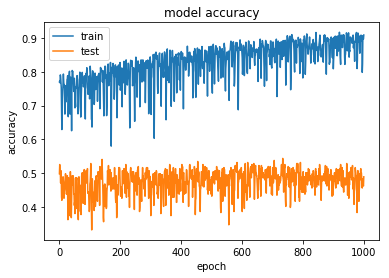

In [236]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [541]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(5, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [542]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight=class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/1000
2839/2839 [==============================] - 3s 997us/step - loss: 1.2628 - acc: 0.1740 - val_loss: 1.3151 - val_acc: 0.4109
Epoch 2/1000
2839/2839 [==============================] - 0s 61us/step - loss: 1.0710 - acc: 0.3202 - val_loss: 1.3482 - val_acc: 0.3323
Epoch 3/1000
2839/2839 [==============================] - 0s 74us/step - loss: 1.0089 - acc: 0.3593 - val_loss: 1.3161 - val_acc: 0.3323
Epoch 4/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.9648 - acc: 0.3878 - val_loss: 1.3395 - val_acc: 0.3323
Epoch 5/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.9652 - acc: 0.3811 - val_loss: 1.3089 - val_acc: 0.3323
Epoch 6/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.9466 - acc: 0.3857 - val_loss: 1.2963 - val_acc: 0.3353
Epoch 7/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.9318 - acc: 0.3857 - val_loss: 1.3542 - val_acc: 

2839/2839 [==============================] - 0s 71us/step - loss: 0.7750 - acc: 0.4470 - val_loss: 1.2605 - val_acc: 0.3233
Epoch 60/1000
2839/2839 [==============================] - 0s 69us/step - loss: 0.7960 - acc: 0.4421 - val_loss: 1.2932 - val_acc: 0.3233
Epoch 61/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.8008 - acc: 0.4301 - val_loss: 1.2942 - val_acc: 0.3202
Epoch 62/1000
2839/2839 [==============================] - 0s 60us/step - loss: 0.7953 - acc: 0.4237 - val_loss: 1.2549 - val_acc: 0.3172
Epoch 63/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7946 - acc: 0.4297 - val_loss: 1.2263 - val_acc: 0.3414
Epoch 64/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7844 - acc: 0.4364 - val_loss: 1.2594 - val_acc: 0.3172
Epoch 65/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.7715 - acc: 0.4315 - val_loss: 1.2454 - val_acc: 0.3505
Epoch 66/1000
2839/2839 [=======================

2839/2839 [==============================] - 0s 71us/step - loss: 0.7122 - acc: 0.4797 - val_loss: 1.1999 - val_acc: 0.4622
Epoch 119/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.7261 - acc: 0.4635 - val_loss: 1.2317 - val_acc: 0.4079
Epoch 120/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.7141 - acc: 0.4745 - val_loss: 1.2609 - val_acc: 0.4139
Epoch 121/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.7357 - acc: 0.4709 - val_loss: 1.2237 - val_acc: 0.4079
Epoch 122/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.6935 - acc: 0.4692 - val_loss: 1.2401 - val_acc: 0.4139
Epoch 123/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.7027 - acc: 0.4720 - val_loss: 1.2565 - val_acc: 0.4048
Epoch 124/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.7269 - acc: 0.4692 - val_loss: 1.1939 - val_acc: 0.4411
Epoch 125/1000
2839/2839 [================

Epoch 177/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.6290 - acc: 0.5090 - val_loss: 1.3075 - val_acc: 0.3716
Epoch 178/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.6496 - acc: 0.4861 - val_loss: 1.3004 - val_acc: 0.3474
Epoch 179/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.6370 - acc: 0.4935 - val_loss: 1.2710 - val_acc: 0.4109
Epoch 180/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.6407 - acc: 0.5062 - val_loss: 1.3353 - val_acc: 0.4018
Epoch 181/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.6751 - acc: 0.4843 - val_loss: 1.2583 - val_acc: 0.3958
Epoch 182/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.6306 - acc: 0.5072 - val_loss: 1.2582 - val_acc: 0.4471
Epoch 183/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.6170 - acc: 0.5213 - val_loss: 1.2942 - val_acc: 0.4139
Epoch 184/1000
2839/2839 [=

Epoch 236/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.6305 - acc: 0.5481 - val_loss: 1.3218 - val_acc: 0.4260
Epoch 237/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.6117 - acc: 0.5527 - val_loss: 1.2843 - val_acc: 0.4320
Epoch 238/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.5768 - acc: 0.5703 - val_loss: 1.2940 - val_acc: 0.4804
Epoch 239/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.5941 - acc: 0.5734 - val_loss: 1.3145 - val_acc: 0.4834
Epoch 240/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.5913 - acc: 0.5780 - val_loss: 1.3196 - val_acc: 0.4199
Epoch 241/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.5496 - acc: 0.5608 - val_loss: 1.3095 - val_acc: 0.4441
Epoch 242/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5681 - acc: 0.5678 - val_loss: 1.4401 - val_acc: 0.3927
Epoch 243/1000
2839/2839 [=

Epoch 295/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.5024 - acc: 0.6182 - val_loss: 1.3613 - val_acc: 0.4955
Epoch 296/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5147 - acc: 0.6058 - val_loss: 1.4339 - val_acc: 0.4894
Epoch 297/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5366 - acc: 0.6048 - val_loss: 1.5139 - val_acc: 0.4381
Epoch 298/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5446 - acc: 0.6097 - val_loss: 1.3730 - val_acc: 0.4532
Epoch 299/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5681 - acc: 0.5946 - val_loss: 1.5184 - val_acc: 0.4532
Epoch 300/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.5245 - acc: 0.6055 - val_loss: 1.4380 - val_acc: 0.4743
Epoch 301/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.5129 - acc: 0.6076 - val_loss: 1.4570 - val_acc: 0.4622
Epoch 302/1000
2839/2839 [=

Epoch 354/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4471 - acc: 0.6513 - val_loss: 1.5784 - val_acc: 0.4622
Epoch 355/1000
2839/2839 [==============================] - 0s 76us/step - loss: 0.4820 - acc: 0.6397 - val_loss: 1.6802 - val_acc: 0.4079
Epoch 356/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.5255 - acc: 0.5963 - val_loss: 1.4118 - val_acc: 0.4199
Epoch 357/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.4678 - acc: 0.6136 - val_loss: 1.5055 - val_acc: 0.4834
Epoch 358/1000
2839/2839 [==============================] - 0s 69us/step - loss: 0.4553 - acc: 0.6478 - val_loss: 1.4146 - val_acc: 0.5529
Epoch 359/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.4813 - acc: 0.6351 - val_loss: 1.4758 - val_acc: 0.4955
Epoch 360/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4662 - acc: 0.6421 - val_loss: 1.5614 - val_acc: 0.4924
Epoch 361/1000
2839/2839 [=

Epoch 413/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4102 - acc: 0.6784 - val_loss: 1.7744 - val_acc: 0.4018
Epoch 414/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.4617 - acc: 0.6139 - val_loss: 1.7834 - val_acc: 0.4169
Epoch 415/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.4422 - acc: 0.6559 - val_loss: 1.7632 - val_acc: 0.4079
Epoch 416/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.4275 - acc: 0.6562 - val_loss: 1.7108 - val_acc: 0.4532
Epoch 417/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4112 - acc: 0.6774 - val_loss: 1.8068 - val_acc: 0.4199
Epoch 418/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.5416 - acc: 0.6333 - val_loss: 1.9721 - val_acc: 0.4048
Epoch 419/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.6101 - acc: 0.5896 - val_loss: 1.5375 - val_acc: 0.4199
Epoch 420/1000
2839/2839 [=

Epoch 472/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.4044 - acc: 0.7048 - val_loss: 1.7508 - val_acc: 0.4622
Epoch 473/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.4522 - acc: 0.6826 - val_loss: 1.9482 - val_acc: 0.4048
Epoch 474/1000
2839/2839 [==============================] - 0s 69us/step - loss: 0.4219 - acc: 0.7013 - val_loss: 1.7370 - val_acc: 0.4562
Epoch 475/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.4023 - acc: 0.7059 - val_loss: 1.7338 - val_acc: 0.4411
Epoch 476/1000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3845 - acc: 0.7083 - val_loss: 1.8892 - val_acc: 0.4713
Epoch 477/1000
2839/2839 [==============================] - 0s 75us/step - loss: 0.3975 - acc: 0.6918 - val_loss: 1.8281 - val_acc: 0.4622
Epoch 478/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4393 - acc: 0.6809 - val_loss: 1.6311 - val_acc: 0.5196
Epoch 479/1000
2839/2839 [=

2839/2839 [==============================] - 0s 69us/step - loss: 0.3505 - acc: 0.7411 - val_loss: 1.9075 - val_acc: 0.4834
Epoch 531/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.4344 - acc: 0.6904 - val_loss: 2.0905 - val_acc: 0.4290
Epoch 532/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.4193 - acc: 0.7048 - val_loss: 1.8449 - val_acc: 0.4894
Epoch 533/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.3702 - acc: 0.7334 - val_loss: 1.7486 - val_acc: 0.5257
Epoch 534/1000
2839/2839 [==============================] - 0s 62us/step - loss: 0.3231 - acc: 0.7654 - val_loss: 1.8965 - val_acc: 0.4955
Epoch 535/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.3439 - acc: 0.7422 - val_loss: 1.9532 - val_acc: 0.4683
Epoch 536/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.3505 - acc: 0.7372 - val_loss: 2.0604 - val_acc: 0.4350
Epoch 537/1000
2839/2839 [================

Epoch 589/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.3103 - acc: 0.7577 - val_loss: 1.9443 - val_acc: 0.4924
Epoch 590/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.3023 - acc: 0.7587 - val_loss: 2.1125 - val_acc: 0.4320
Epoch 591/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.3865 - acc: 0.6862 - val_loss: 1.9183 - val_acc: 0.4502
Epoch 592/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.3259 - acc: 0.7256 - val_loss: 2.0336 - val_acc: 0.4713
Epoch 593/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.3150 - acc: 0.7443 - val_loss: 1.8954 - val_acc: 0.4622
Epoch 594/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.3540 - acc: 0.7091 - val_loss: 1.9165 - val_acc: 0.4653
Epoch 595/1000
2839/2839 [==============================] - 0s 65us/step - loss: 0.3612 - acc: 0.7006 - val_loss: 1.9024 - val_acc: 0.5196
Epoch 596/1000
2839/2839 [=

2839/2839 [==============================] - 0s 59us/step - loss: 0.3375 - acc: 0.7534 - val_loss: 2.1891 - val_acc: 0.4502
Epoch 648/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.2822 - acc: 0.7714 - val_loss: 2.1975 - val_acc: 0.4804
Epoch 649/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.2687 - acc: 0.7897 - val_loss: 2.1972 - val_acc: 0.4622
Epoch 650/1000
2839/2839 [==============================] - 0s 68us/step - loss: 0.2801 - acc: 0.7774 - val_loss: 2.1537 - val_acc: 0.4441
Epoch 651/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.4759 - acc: 0.6629 - val_loss: 1.7583 - val_acc: 0.4622
Epoch 652/1000
2839/2839 [==============================] - 0s 59us/step - loss: 0.4153 - acc: 0.6650 - val_loss: 1.9084 - val_acc: 0.5166
Epoch 653/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.2961 - acc: 0.7541 - val_loss: 1.9939 - val_acc: 0.5136
Epoch 654/1000
2839/2839 [================

2839/2839 [==============================] - 0s 67us/step - loss: 0.2623 - acc: 0.8024 - val_loss: 2.2774 - val_acc: 0.4532
Epoch 707/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.2607 - acc: 0.7848 - val_loss: 2.2408 - val_acc: 0.4924
Epoch 708/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.2540 - acc: 0.7901 - val_loss: 2.3469 - val_acc: 0.4562
Epoch 709/1000
2839/2839 [==============================] - 0s 78us/step - loss: 0.2885 - acc: 0.7703 - val_loss: 2.2401 - val_acc: 0.4532
Epoch 710/1000
2839/2839 [==============================] - 0s 86us/step - loss: 0.3398 - acc: 0.7231 - val_loss: 2.1206 - val_acc: 0.4743
Epoch 711/1000
2839/2839 [==============================] - 0s 59us/step - loss: 0.3282 - acc: 0.7400 - val_loss: 2.2396 - val_acc: 0.5136
Epoch 712/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.2703 - acc: 0.7961 - val_loss: 2.2995 - val_acc: 0.5136
Epoch 713/1000
2839/2839 [================

2839/2839 [==============================] - 0s 59us/step - loss: 0.2456 - acc: 0.8116 - val_loss: 2.6182 - val_acc: 0.4079
Epoch 766/1000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3343 - acc: 0.7231 - val_loss: 2.2856 - val_acc: 0.4502
Epoch 767/1000
2839/2839 [==============================] - 0s 96us/step - loss: 0.2694 - acc: 0.7658 - val_loss: 2.4588 - val_acc: 0.5015
Epoch 768/1000
2839/2839 [==============================] - 0s 82us/step - loss: 0.2426 - acc: 0.8101 - val_loss: 2.4892 - val_acc: 0.5227
Epoch 769/1000
2839/2839 [==============================] - 0s 59us/step - loss: 0.2623 - acc: 0.8024 - val_loss: 2.3846 - val_acc: 0.5166
Epoch 770/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.2518 - acc: 0.8130 - val_loss: 2.3773 - val_acc: 0.5196
Epoch 771/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.2406 - acc: 0.8190 - val_loss: 2.4360 - val_acc: 0.4924
Epoch 772/1000
2839/2839 [================

2839/2839 [==============================] - 0s 70us/step - loss: 0.4418 - acc: 0.6738 - val_loss: 2.4598 - val_acc: 0.4502
Epoch 825/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.2672 - acc: 0.7848 - val_loss: 2.6252 - val_acc: 0.4834
Epoch 826/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.2152 - acc: 0.8337 - val_loss: 2.4955 - val_acc: 0.5015
Epoch 827/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.2810 - acc: 0.8035 - val_loss: 2.4978 - val_acc: 0.4864
Epoch 828/1000
2839/2839 [==============================] - 0s 72us/step - loss: 0.3689 - acc: 0.7337 - val_loss: 2.2270 - val_acc: 0.5196
Epoch 829/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.2600 - acc: 0.8006 - val_loss: 2.7530 - val_acc: 0.4804
Epoch 830/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.2212 - acc: 0.8306 - val_loss: 2.5938 - val_acc: 0.4894
Epoch 831/1000
2839/2839 [================

2839/2839 [==============================] - 0s 64us/step - loss: 0.2012 - acc: 0.8542 - val_loss: 2.7292 - val_acc: 0.5045
Epoch 884/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.1994 - acc: 0.8531 - val_loss: 2.8304 - val_acc: 0.5076
Epoch 885/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.1977 - acc: 0.8535 - val_loss: 3.2795 - val_acc: 0.4441
Epoch 886/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.2771 - acc: 0.8119 - val_loss: 3.4896 - val_acc: 0.4109
Epoch 887/1000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4702 - acc: 0.7052 - val_loss: 2.8961 - val_acc: 0.4532
Epoch 888/1000
2839/2839 [==============================] - 0s 70us/step - loss: 0.2816 - acc: 0.7915 - val_loss: 2.8164 - val_acc: 0.4773
Epoch 889/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.2039 - acc: 0.8426 - val_loss: 2.8251 - val_acc: 0.4592
Epoch 890/1000
2839/2839 [================

2839/2839 [==============================] - 0s 71us/step - loss: 0.2015 - acc: 0.8334 - val_loss: 2.6971 - val_acc: 0.4864
Epoch 942/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.2057 - acc: 0.8239 - val_loss: 2.6950 - val_acc: 0.4834
Epoch 943/1000
2839/2839 [==============================] - 0s 71us/step - loss: 0.1973 - acc: 0.8478 - val_loss: 2.9253 - val_acc: 0.4653
Epoch 944/1000
2839/2839 [==============================] - 0s 67us/step - loss: 0.2038 - acc: 0.8422 - val_loss: 2.9466 - val_acc: 0.4441
Epoch 945/1000
2839/2839 [==============================] - 0s 66us/step - loss: 0.3009 - acc: 0.7661 - val_loss: 2.7075 - val_acc: 0.4773
Epoch 946/1000
2839/2839 [==============================] - 0s 63us/step - loss: 0.2042 - acc: 0.8355 - val_loss: 2.8491 - val_acc: 0.4864
Epoch 947/1000
2839/2839 [==============================] - 0s 74us/step - loss: 0.1814 - acc: 0.8665 - val_loss: 2.8545 - val_acc: 0.4924
Epoch 948/1000
2839/2839 [================

2839/2839 [==============================] - 0s 69us/step - loss: 0.1670 - acc: 0.8820 - val_loss: 3.0295 - val_acc: 0.4653


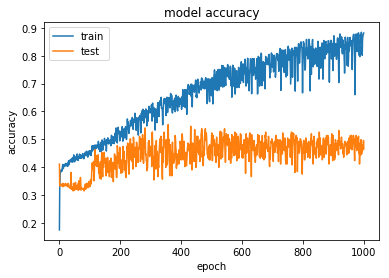

In [543]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [622]:
predictions = model.predict(X_test_w2v)
model_metrics(predictions, X_test, y_cat_test_w2v)

0.991869918699187


In [544]:
X_test_cat_mod = model.predict(X_test_w2v)

In [545]:
X_test_cat_mod_df = pd.DataFrame(X_test_cat_mod )

In [546]:
X_test_cat_mod_df['loss'] = np.where(X_test_cat_mod_df[0]> X_test_cat_mod_df[3], 1, 0)

In [547]:
X_test_cat_mod_df['gain'] = np.where(X_test_cat_mod_df[4]> X_test_cat_mod_df[1], 1, 0)

In [548]:
X_test_cat_mod_df_2 = pd.merge(X_test_cat_mod_df, y_cat_test_w2v, left_index=True, right_index=True, how='inner')

In [588]:
X_test_cat_mod_df_2['gain_large'] = np.where(X_test_cat_mod_df[4]> X_test_cat_mod_df[2], 1, 0)

In [597]:
X_test_cat_mod_df_2['loss_large'] = np.where(X_test_cat_mod_df[0]> X_test_cat_mod_df[2], 1, 0)

In [602]:
X_test_cat_mod_df_2['loss_large_true'] = np.where((X_test_cat_mod_df_2['loss_large'] == 1) & (X_test_cat_mod_df_2['2'] == 1) | (X_test_cat_mod_df_2['1'] == 1), 1, 0)

In [593]:
X_test_cat_mod_df_2['gain_large_true'] = np.where((X_test_cat_mod_df_2['gain_large'] == 1) & (X_test_cat_mod_df_2['4'] == 1) | (X_test_cat_mod_df_2['5'] == 1), 1, 0)

In [589]:
X_test_cat_mod_df_2['gain_true_true'] = np.where((X_test_cat_mod_df_2['gain'] == 1) & (X_test_cat_mod_df_2['4'] == 1) | (X_test_cat_mod_df_2['5'] == 1), 1, 0)

In [591]:
X_test_cat_mod_df_2['loss_large'] = np.where(X_test_cat_mod_df[0]> X_test_cat_mod_df[2], 1, 0)

In [566]:
X_test_cat_mod_df_2['gain_stay'] = np.where((X_test_cat_mod_df_2['gain'] == 1) & (X_test_cat_mod_df_2['3'] == 1), 1, 0)

In [569]:
X_test_cat_mod_df_2['loss_true_true'] = np.where((X_test_cat_mod_df_2['loss'] == 1) & (X_test_cat_mod_df_2['2'] == 1) | (X_test_cat_mod_df_2['1'] == 1), 1, 0)

In [572]:
X_test_cat_mod_df_2['loss_stay'] = np.where((X_test_cat_mod_df_2['loss'] == 1) & (X_test_cat_mod_df_2['3'] == 1), 1, 0)

In [561]:
X_test_cat_mod_df_2['gain_true_true'].sum() / X_test_cat_mod_df_2['gain'].sum()

0.6991869918699187

In [596]:
X_test_cat_mod_df_2['gain_large_true'].sum() / X_test_cat_mod_df_2['gain_large'].sum()

0.9791666666666666

In [604]:
X_test_cat_mod_df_2['loss_large_true'].sum() / X_test_cat_mod_df_2['loss_large'].sum()

0.7

In [568]:
X_test_cat_mod_df_2['gain_stay'].sum() / X_test_cat_mod_df_2['gain'].sum()

0.2926829268292683

In [571]:
X_test_cat_mod_df_2['loss_true_true'].sum() / X_test_cat_mod_df_2['loss'].sum()

0.42857142857142855

In [574]:
X_test_cat_mod_df_2['loss_stay'].sum() / X_test_cat_mod_df_2['loss'].sum()

0.42857142857142855

In [584]:
X_test_cat_mod_df_2['gain_true_true'].sum() / (X_test_cat_mod_df_2['4'].sum() + X_test_cat_mod_df_2['5'].sum())

0.6615384615384615

In [576]:
X_test_cat_mod_df_2['loss'].sum() / (X_test_cat_mod_df_2['1'].sum() + X_test_cat_mod_df_2['2'].sum())

1.105263157894737

In [577]:
X_test_cat_mod_df_2['gain_true_true'].sum()

86

In [583]:
X_test_cat_mod_df_2['loss_true_true'].sum() / (X_test_cat_mod_df_2['1'].sum() + X_test_cat_mod_df_2['2'].sum())

0.47368421052631576

In [581]:
X_test_cat_mod_df_2['loss'].sum() / (X_test_cat_mod_df_2['1'].sum() + X_test_cat_mod_df_2['2'].sum())

1.105263157894737

In [580]:
X_test_cat_mod_df_2['loss_stay'].sum()

27

In [605]:
X_test_cat_mod_df_2['gain_large_true'].sum()

14